# Relocate the ball drop test
2022.11.4 Kurama Okubo

2022.11.23 update rescale with u_normfact

2023.12.31 update for master plot

This notebook performs the relocation of balldrop computing characteristic function CF.

We implemented the resp_removal using the PAZ estimated with the LDV measurement in the beginning of processing.

In [19]:
import os
import obspy
from obspy import read, Stream, Trace
from scipy import signal
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import numpy as np
import pandas as pd
import datetime
from tqdm import tqdm
import warnings

from matplotlib import ticker, cm
from matplotlib.colors import LogNorm
from matplotlib import ticker, cm, colors

from SBENCHreader import SBENCHreader

from compute_CF_func import get_autopick_function, eval_biax_4m_eventloc
from remove_resp_digitalfilt import *

os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 4.75
plt.rcParams["xtick.major.width"] = 0.75
plt.rcParams["xtick.minor.size"] = 3
plt.rcParams["xtick.minor.width"] = 0.4
plt.rcParams["xtick.minor.visible"] = True

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 4.75
plt.rcParams["ytick.major.width"] = 0.75
plt.rcParams["ytick.minor.size"] = 3
plt.rcParams["ytick.minor.width"] = 0.4
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams["savefig.transparent"] = False
plt.rcParams['axes.linewidth'] = 0.75

from obspy.core.utcdatetime import UTCDateTime  
os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion
UTCDateTime.DEFAULT_PRECISION = 8

## Parameters

In [20]:
starttime=datetime.datetime(2022,11,4) # Used to unify the dataset

fs = 1e7; #original sampling rate

PickNumStation = 4 # number of stations used to pick
FW = 5 #10 update for new BD test. 
BW = 200 #50 update for new BD test. 
autopick_threshold = 15 #15 #update for new BD test. 
fap_twin = 3 #[ms] window length around peak amplitude to compute fap for computational efficiency

# Vrng = [6560]
# Vrng = np.linspace(5800, 6700, 91)
vfixed_id = 40
Vrng = np.linspace(5800, 7200, 141)

# parameters for instrumental response removal
PAZ_case = "fronttop"
D = sio.loadmat("../../AEsensor_Calibration/AEsensor_Calibration_ARX/data/AE_resp_dataandcoef_fronttop.mat"); # we used fronttop in this example notebook
poles = np.squeeze(D["p"])
zeros = np.squeeze(D["z"])
scale_fac = np.squeeze(D["k"])
u_normfact = np.squeeze(D["u_normfact"]) # normalized factor during the estimation of poles and zeros. see the following cell of note.
pre_filt = (1e4, 2e4, 1e6, 2e6)
water_level = 60

taper_max_percentage = 0.1# taper percentage after bandpass


gridsize = 1.0e-3 #0.025e-3,1.0e-3 #[m]

channel_finame = '../../../Others/AEchanneltable/AEsensorlocation_onFB03_table.csv'
balldropid_finame = '../data/balldrop_id.txt'

datadir="../data/DATA_RAW"
outputdir = "../data/DATA_computeCF"
print(Vrng)
print("vfixed: {}".format(Vrng[vfixed_id]))

[5800. 5810. 5820. 5830. 5840. 5850. 5860. 5870. 5880. 5890. 5900. 5910.
 5920. 5930. 5940. 5950. 5960. 5970. 5980. 5990. 6000. 6010. 6020. 6030.
 6040. 6050. 6060. 6070. 6080. 6090. 6100. 6110. 6120. 6130. 6140. 6150.
 6160. 6170. 6180. 6190. 6200. 6210. 6220. 6230. 6240. 6250. 6260. 6270.
 6280. 6290. 6300. 6310. 6320. 6330. 6340. 6350. 6360. 6370. 6380. 6390.
 6400. 6410. 6420. 6430. 6440. 6450. 6460. 6470. 6480. 6490. 6500. 6510.
 6520. 6530. 6540. 6550. 6560. 6570. 6580. 6590. 6600. 6610. 6620. 6630.
 6640. 6650. 6660. 6670. 6680. 6690. 6700. 6710. 6720. 6730. 6740. 6750.
 6760. 6770. 6780. 6790. 6800. 6810. 6820. 6830. 6840. 6850. 6860. 6870.
 6880. 6890. 6900. 6910. 6920. 6930. 6940. 6950. 6960. 6970. 6980. 6990.
 7000. 7010. 7020. 7030. 7040. 7050. 7060. 7070. 7080. 7090. 7100. 7110.
 7120. 7130. 7140. 7150. 7160. 7170. 7180. 7190. 7200.]
vfixed: 6200.0


### u_normfact

The input $u$ (m/s; LDV) and output $y$ (V; AE sensor) signals are normalized with its standard deviation when estimating the poles and zeros to stabilize the least square method. The estimated scaling factor is thus a factor of `u_normfact` (indicated as $\kappa$) as follows:

$$\bf{y} = G \bf{u}$$
$$\bf{y/\sigma_y} = G'\bf{u/\sigma_u}$$
$$\bf{y} = \left(\dfrac{\sigma_y}{\sigma_u} G' \right) \bf{u}$$ 
$$\kappa = \dfrac{\sigma_u}{\sigma_y} $$
$$G = \dfrac{1}{\kappa}G'$$

$$\bf{u} = G^{-1} \bf{y}$$
$$\bf{u} = \kappa G'^{-1} \bf{y}.$$

The estimated poles, zeros and scale_factor correspond to the $G'$. ~~Thus, we need to rescale the scale factor by $1/\kappa$ when removing the instrumental response. The gain from PAZ with LDV is thus scaling factor devided by $\kappa$ [V/(m/s)], including the amplification of preamp (+40dB).~~ The new version of `AEsensor_Calibration_ARX` already rescaled the `scale_fac` by $1/\kappa$.

In [21]:
scale_fac, u_normfact, scale_fac

(array(894.99095553), array(0.00012082), array(894.99095553))

In [22]:
D.keys()

dict_keys(['__header__', '__version__', '__globals__', 'AIC', 'Na', 'Nb', 'k', 'p', 'tf_a', 'tf_b', 'u_input_raw', 'u_normfact', 'y_output_raw', 'z'])

In [23]:
d1 = D['u_input_raw']
d2 = D['y_output_raw']
d3 = D['u_normfact']

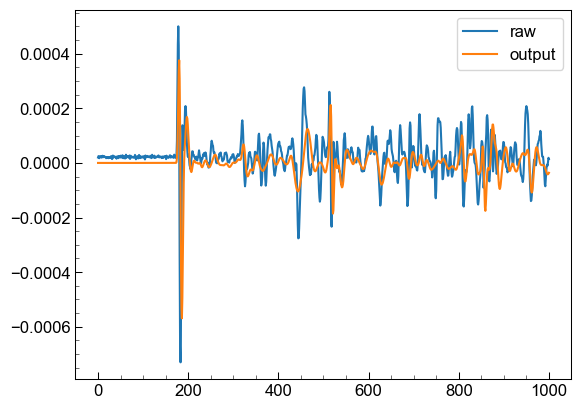

In [24]:
plt.plot(d1, label="raw")
plt.plot(d2*d3, label="output")
plt.legend()

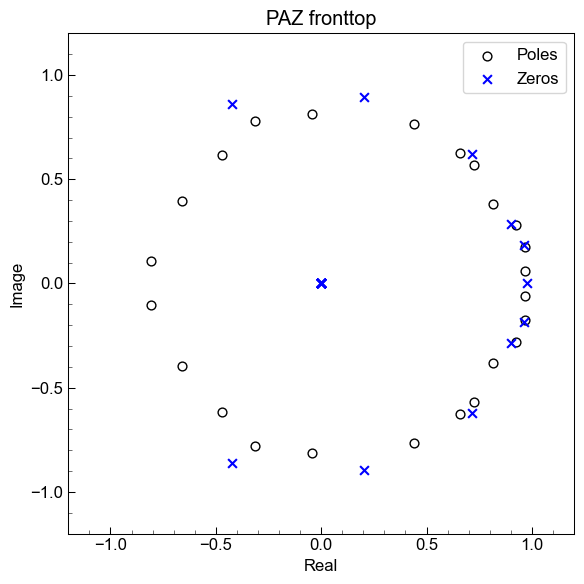

In [25]:
fig, ax = plt.subplots(1,1,figsize=(6, 6))

ax.scatter(poles.real, poles.imag, s=40, label="Poles", marker = "o", c="w", edgecolors="k")
ax.scatter(zeros.real, zeros.imag, s=40, label="Zeros", marker = "x", c="b")

ax.legend(loc=0)

ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)

ax.set_xlabel('Real')
ax.set_ylabel('Image')
ax.set_title(f'PAZ {PAZ_case}')
plt.tight_layout()


## Read channel array

In [26]:
df_array = pd.read_csv(channel_finame)

channel_loc={}

for i in range(len(df_array)):
    stnm = df_array.iloc[i].Instrument_Label
    xtemp = df_array.iloc[i].North.astype('float')
    ytemp = df_array.iloc[i].East.astype('float')
    ztemp = df_array.iloc[i].Down.astype('float')
    channel_loc[stnm] = [xtemp, ytemp, ztemp]
channel_loc

{'OL01': [190.0, 50.0, 70.0],
 'OL02': [410.0, 50.0, 70.0],
 'OL03': [640.0, 50.0, 70.0],
 'OL04': [910.0, 50.0, 70.0],
 'OL05': [1160.0, 50.0, 70.0],
 'OL06': [1370.0, 50.0, 70.0],
 'OL07': [1660.0, 50.0, 70.0],
 'OL08': [1910.0, 50.0, 70.0],
 'OL09': [2160.0, 50.0, 70.0],
 'OL10': [2410.0, 50.0, 70.0],
 'OL11': [2650.0, 50.0, 70.0],
 'OL12': [2910.0, 50.0, 70.0],
 'OL13': [3160.0, 50.0, 70.0],
 'OL14': [3410.0, 50.0, 70.0],
 'OL15': [3660.0, 50.0, 70.0],
 'OL16': [3910.0, 50.0, 70.0],
 'OL17': [285.0, -50.0, 70.0],
 'OL18': [535.0, -50.0, 70.0],
 'OL19': [785.0, -50.0, 70.0],
 'OL20': [1035.0, -50.0, 70.0],
 'OL21': [1285.0, -50.0, 70.0],
 'OL22': [1535.0, -50.0, 70.0],
 'OL23': [1785.0, -50.0, 70.0],
 'OL24': [2035.0, -50.0, 70.0],
 'OL25': [2285.0, -50.0, 70.0],
 'OL26': [2535.0, -50.0, 70.0],
 'OL27': [2785.0, -50.0, 70.0],
 'OL28': [3035.0, -50.0, 70.0],
 'OL29': [3285.0, -50.0, 70.0],
 'OL30': [3535.0, -50.0, 70.0],
 'OL31': [3785.0, -50.0, 70.0],
 'OL32': [4035.0, -50.0, 70.0]}

## Read balldrop ids

In [27]:
# Prescribed location of ball drop
d0 = 220 # [mm] stating location 
d_BD = 120 #spacing of ball drop

NBD = 32

bd_x = []
for i in range(NBD):
    bd_x.append(d0+i*d_BD) 

In [28]:
# make balldrop id file
with open("../data/balldrop_id.txt", "w") as fo:
    for bx in bd_x:
        fo.write("BD_{:04d}\n".format(bx))
        
    

In [29]:
# read and store the traces
st_iter = []

for ii in range(3):
    st_all = Stream()
    for bx in bd_x:  
        fname = 'BD02_{:04d}_{:d}'.format(bx, ii+1)
        datmat,_ ,_ = SBENCHreader(0,0.5e-3,'../data/DATA_RAW/',f'{fname}', fs_read=0, pretrigger=True)
        for sensor_i in range(NBD):
            tr = Trace()
            tr.stats.station="OL{:02d}".format(sensor_i+1)
            tr.stats.location = "{:04d}".format(bx)
            tr.stats.channel="A"
            tr.stats.delta=1e-7
            tr.data = datmat[:, sensor_i]
            st_all.append(tr)
            
    st_iter.append(st_all)

100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 2191.67it/s]


In [30]:
st_iter[0].select(station="OL01")

32 Trace(s) in Stream:

.OL01.0220.A | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:00.00049990Z | 10000000.0 Hz, 5000 samples
...
(30 other traces)
...
.OL01.3940.A | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:00.00049990Z | 10000000.0 Hz, 5000 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

## Check reproducibility of balldrop test and choose best impact
In this case, we choose the one of three traces with highest peak amplitude.

To choose the event id, we first pick the closest AE. Compute the distance between traces, and then pick the one of the coherent pair with higher peak amplitude.


In [31]:
iter_id = dict()
for bx in bd_x:
    dataID = "{:04d}".format(bx)

    # select the closest AE sensor
    dist_all = [np.abs(bx - x[1][0]) for x in channel_loc.items()]
    closest_stid = list(channel_loc.keys())[np.argsort(dist_all)[0]]

    # select traces
    tr_1 = st_iter[0].select(station = closest_stid, location=dataID)[0]
    tr_2 = st_iter[1].select(station = closest_stid, location=dataID)[0]
    tr_3 = st_iter[2].select(station = closest_stid, location=dataID)[0]

    # 1. compute euclidean distance
    euc_dist=dict()
    euc_dist["12"] = np.linalg.norm(tr_1.data - tr_2.data, ord=2)
    euc_dist["13"] = np.linalg.norm(tr_1.data - tr_3.data, ord=2)
    euc_dist["23"] = np.linalg.norm(tr_2.data - tr_3.data, ord=2)

#     print(euc_dist)
    
    # select closest pair
    closest_key = sorted(euc_dist.items(), key=lambda item: item[1])[0][0]
    key1, key2 = str(closest_key)

    # 2. compute max value
    exec("m_a = np.abs(tr_{}.data).max()".format(key1))
    exec("m_b = np.abs(tr_{}.data).max()".format(key2))
#     print(key1, key2)
    # select the trial index with the maximum amplitude
    if np.argmax([m_a, m_b]) == 0:
        iter_id[dataID] = int(key1)
    else:
        iter_id[dataID] = int(key2)

    

In [32]:
iter_id

{'0220': 1,
 '0340': 1,
 '0460': 1,
 '0580': 3,
 '0700': 2,
 '0820': 1,
 '0940': 1,
 '1060': 3,
 '1180': 3,
 '1300': 3,
 '1420': 2,
 '1540': 2,
 '1660': 2,
 '1780': 2,
 '1900': 3,
 '2020': 3,
 '2140': 2,
 '2260': 1,
 '2380': 1,
 '2500': 2,
 '2620': 1,
 '2740': 2,
 '2860': 2,
 '2980': 2,
 '3100': 1,
 '3220': 3,
 '3340': 2,
 '3460': 3,
 '3580': 1,
 '3700': 1,
 '3820': 1,
 '3940': 2}

In [33]:
st_raw_bd = Stream()

# Check reproducibility of balldrop test
figdir_reproducibility = "../figure/p01_reproducibility"
if not os.path.exists(figdir_reproducibility):
    os.makedirs(figdir_reproducibility)

for bx in tqdm(bd_x):
#     bx = bd_x[10]
    dataID = "{:04d}".format(bx)
    i_iter = iter_id[dataID]

    for sensor_i in range(NBD): 
        #         sensor_i = 8
        stid = "OL{:02d}".format(sensor_i+1)
        tr_1 = st_iter[0].select(station=stid, location=dataID)[0]
        tr_2 = st_iter[1].select(station=stid, location=dataID)[0]
        tr_3 = st_iter[2].select(station=stid, location=dataID)[0]
        tvec=tr_1.times()*1e3

        casename = "{}_{:04d}".format(stid, bx)
        bd_loc = np.array([bx, 0, 0])
    
        dist = np.linalg.norm(channel_loc[stid] - bd_loc, ord=2)
        
        #---choose trace with maximum amplitude and store into the stream---#
        tr_selected = tr_1.copy() # copy metadata
        tr_selected.stats.dist = dist # store distance
#         peak_amp = [max(np.abs(tr_1.data)), max(np.abs(tr_2.data)), max(np.abs(tr_3.data))]
        
#         trial_id = peak_amp.index(sorted(peak_amp, reverse=True)[peakind]) 
            
#         trial_id = peak_amp.index(max(peak_amp))
#         print(trial_id)
#         tr_selected.stats.trial_id = trial_id
#         exec("tr_selected.data = tr_{:d}.data".format(trial_id+1)) # replace traces
        exec("tr_selected.data = tr_{:d}.data".format(i_iter)) # replace traces
        tr_selected.stats.i_iter=i_iter
        st_raw_bd.append(tr_selected)
        
        # plot figure
        if dist>300:
            continue

        fig, ax = plt.subplots(1,1,figsize=(8, 3))

        ax.plot(tvec, tr_1.data, "b-", label="1st")
        ax.plot(tvec, tr_2.data, "r--", label="2nd")
        ax.plot(tvec, tr_3.data, "g--", label="3rd")
        ax.plot(tvec, tr_selected.data, "k--", label="selected No.{}".format(i_iter))
        ax.legend(loc=4, ncol=2)

        ax.set_xlim(0, 0.5)
        ax.set_ylim(-8, 8)

        ax.set_xlabel('Time [ms]')
        ax.set_ylabel('Amplitude [V]')
        ax.set_title('Event {} Dist:{:.1f}mm'.format(casename, dist))
        plt.tight_layout()

        plt.savefig(figdir_reproducibility+"/balldrop_reproducibility_{}.png".format(casename), format="png", dpi=150)
        plt.clf() 
        plt.close()
        
 

100%|███████████████████████████████████████████| 32/32 [00:19<00:00,  1.65it/s]


In [34]:
st_raw_bd.select(location="{:04d}".format(bd_x[10]))

32 Trace(s) in Stream:

.OL01.1420.A | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:00.00049990Z | 10000000.0 Hz, 5000 samples
...
(30 other traces)
...
.OL32.1420.A | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:00.00049990Z | 10000000.0 Hz, 5000 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

# Pick the first arrival and relocate the source location

Characteristic function is computed as following (see eq. 2.15 in Samson's thesis):

$$ F_i = \dfrac{\Sigma_{j = i+1}^{i+FW} A_j^2}{\Sigma_{j = i-1}^{i-BW} A_j^2} $$

$FW, BW$ is the back and forward window length, respectively. $A_j$ is the amplitude of signal. 

We used the normalized auto-pick function as follows: 
$$ F_i = \dfrac{BW}{FW} \dfrac{\Sigma_{j = i+1}^{i+FW} A_j^2}{\Sigma_{j = i-1}^{i-BW} A_j^2} -1 $$


0220 already exists. skip this case.
---------------
Start Processing 0220
---------------

0220


Grid searching:: 100%|████████████████████████| 201/201 [00:41<00:00,  4.83it/s]


0340 already exists. skip this case.
---------------
Start Processing 0340
---------------

0340


Grid searching:: 100%|████████████████████████| 201/201 [00:43<00:00,  4.60it/s]


0460 already exists. skip this case.
---------------
Start Processing 0460
---------------

0460


Grid searching:: 100%|████████████████████████| 201/201 [00:41<00:00,  4.82it/s]


0580 already exists. skip this case.
---------------
Start Processing 0580
---------------

0580


Grid searching:: 100%|████████████████████████| 201/201 [00:40<00:00,  4.94it/s]


0700 already exists. skip this case.
---------------
Start Processing 0700
---------------

0700


Grid searching:: 100%|████████████████████████| 201/201 [00:41<00:00,  4.81it/s]


0820 already exists. skip this case.
---------------
Start Processing 0820
---------------

0820


Grid searching:: 100%|████████████████████████| 201/201 [00:41<00:00,  4.85it/s]


0940 already exists. skip this case.
---------------
Start Processing 0940
---------------

0940


100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 13.03it/s]
/var/folders/6n/nsqc1sbn1kn5ccc7y51plgz00000gn/T/ipykernel_69299/1126984069.py:130: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,1,figsize=(10, 10))
Grid searching:: 100%|████████████████████████| 201/201 [00:42<00:00,  4.75it/s]


1060 already exists. skip this case.
---------------
Start Processing 1060
---------------

1060


Grid searching:: 100%|████████████████████████| 201/201 [00:42<00:00,  4.75it/s]


1180 already exists. skip this case.
---------------
Start Processing 1180
---------------

1180


Grid searching:: 100%|████████████████████████| 201/201 [00:42<00:00,  4.72it/s]


1300 already exists. skip this case.
---------------
Start Processing 1300
---------------

1300


Grid searching:: 100%|████████████████████████| 201/201 [00:40<00:00,  4.92it/s]


1420 already exists. skip this case.
---------------
Start Processing 1420
---------------

1420


Grid searching:: 100%|████████████████████████| 201/201 [00:40<00:00,  4.94it/s]


1540 already exists. skip this case.
---------------
Start Processing 1540
---------------

1540


Grid searching:: 100%|████████████████████████| 201/201 [00:41<00:00,  4.87it/s]


1660 already exists. skip this case.
---------------
Start Processing 1660
---------------

1660


Grid searching:: 100%|████████████████████████| 201/201 [00:41<00:00,  4.83it/s]


1780 already exists. skip this case.
---------------
Start Processing 1780
---------------

1780


Grid searching:: 100%|████████████████████████| 201/201 [00:41<00:00,  4.89it/s]


1900 already exists. skip this case.
---------------
Start Processing 1900
---------------

1900


Grid searching:: 100%|████████████████████████| 201/201 [00:41<00:00,  4.88it/s]


2020 already exists. skip this case.
---------------
Start Processing 2020
---------------

2020


Grid searching:: 100%|████████████████████████| 201/201 [00:41<00:00,  4.85it/s]


2140 already exists. skip this case.
---------------
Start Processing 2140
---------------

2140


Grid searching:: 100%|████████████████████████| 201/201 [00:40<00:00,  4.93it/s]


2260 already exists. skip this case.
---------------
Start Processing 2260
---------------

2260


Grid searching:: 100%|████████████████████████| 201/201 [00:40<00:00,  4.96it/s]


2380 already exists. skip this case.
---------------
Start Processing 2380
---------------

2380


Grid searching:: 100%|████████████████████████| 201/201 [00:40<00:00,  4.92it/s]


2500 already exists. skip this case.
---------------
Start Processing 2500
---------------

2500


Grid searching:: 100%|████████████████████████| 201/201 [00:43<00:00,  4.58it/s]


2620 already exists. skip this case.
---------------
Start Processing 2620
---------------

2620


Grid searching:: 100%|████████████████████████| 201/201 [00:41<00:00,  4.89it/s]


2740 already exists. skip this case.
---------------
Start Processing 2740
---------------

2740


Grid searching:: 100%|████████████████████████| 201/201 [00:41<00:00,  4.90it/s]


2860 already exists. skip this case.
---------------
Start Processing 2860
---------------

2860


Grid searching:: 100%|████████████████████████| 201/201 [00:40<00:00,  4.92it/s]


2980 already exists. skip this case.
---------------
Start Processing 2980
---------------

2980


Grid searching:: 100%|████████████████████████| 201/201 [00:41<00:00,  4.89it/s]


3100 already exists. skip this case.
---------------
Start Processing 3100
---------------

3100


Grid searching:: 100%|████████████████████████| 201/201 [00:40<00:00,  4.91it/s]


3220 already exists. skip this case.
---------------
Start Processing 3220
---------------

3220


Grid searching:: 100%|████████████████████████| 201/201 [00:41<00:00,  4.86it/s]


3340 already exists. skip this case.
---------------
Start Processing 3340
---------------

3340


Grid searching:: 100%|████████████████████████| 201/201 [00:40<00:00,  4.94it/s]


3460 already exists. skip this case.
---------------
Start Processing 3460
---------------

3460


Grid searching:: 100%|████████████████████████| 201/201 [00:40<00:00,  4.91it/s]


3580 already exists. skip this case.
---------------
Start Processing 3580
---------------

3580


Grid searching:: 100%|████████████████████████| 201/201 [00:40<00:00,  4.94it/s]


3700 already exists. skip this case.
---------------
Start Processing 3700
---------------

3700


Grid searching:: 100%|████████████████████████| 201/201 [00:41<00:00,  4.90it/s]


3820 already exists. skip this case.
---------------
Start Processing 3820
---------------

3820


Grid searching:: 100%|████████████████████████| 201/201 [00:40<00:00,  4.99it/s]


3940 already exists. skip this case.
---------------
Start Processing 3940
---------------

3940


Grid searching:: 100%|████████████████████████| 201/201 [00:41<00:00,  4.79it/s]


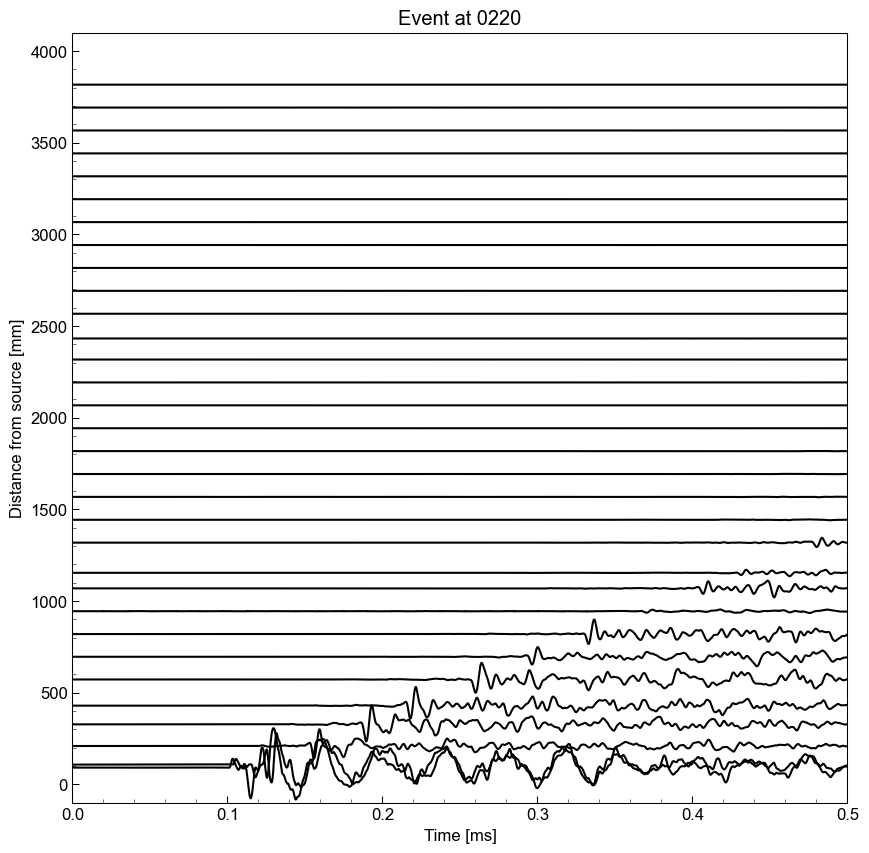

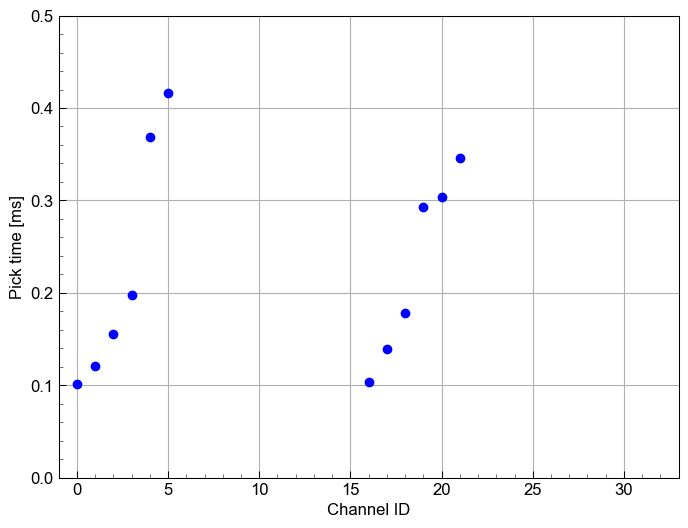

<Figure size 1000x1000 with 0 Axes>

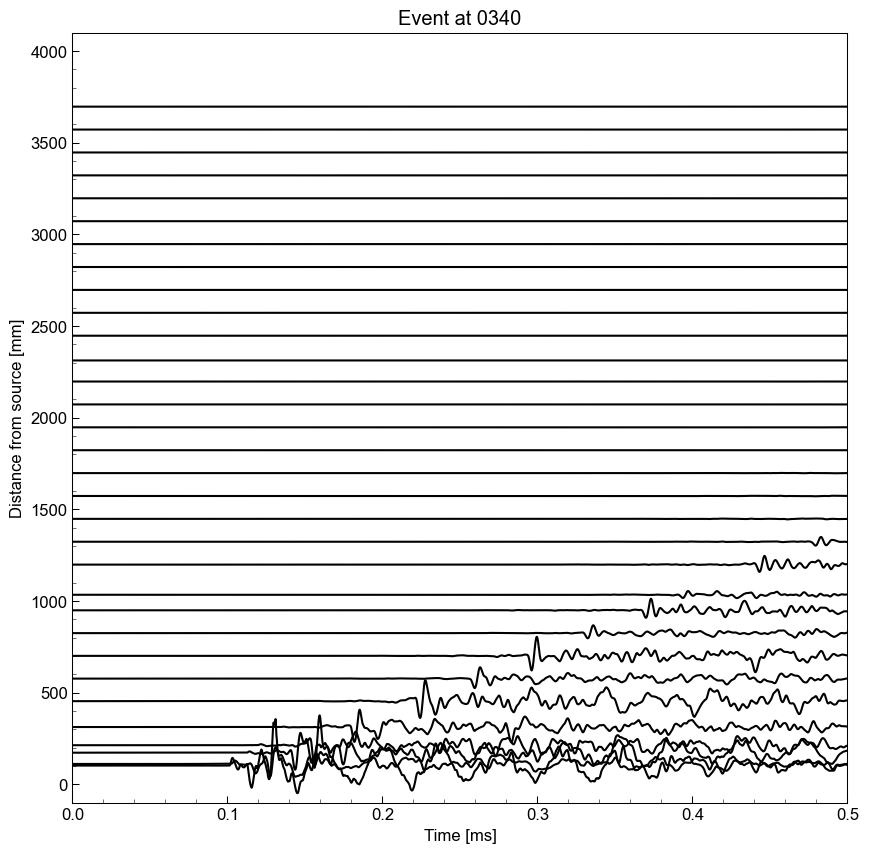

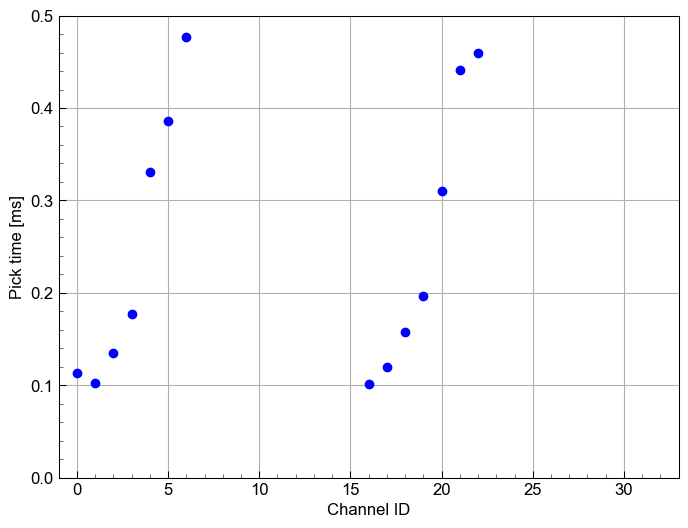

<Figure size 1000x1000 with 0 Axes>

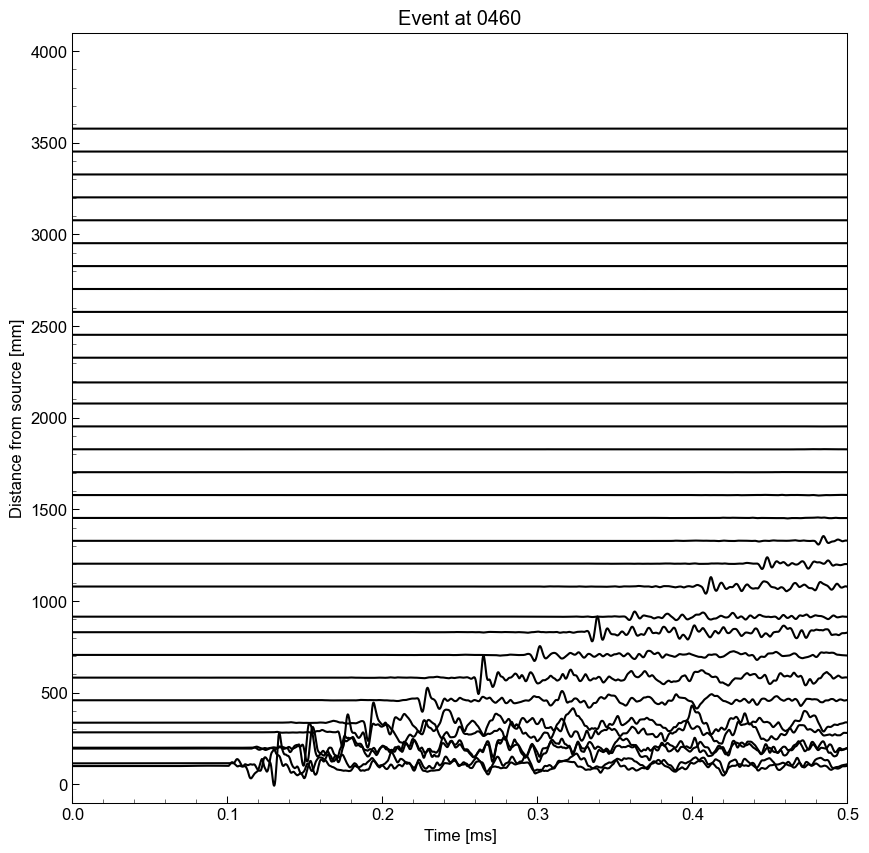

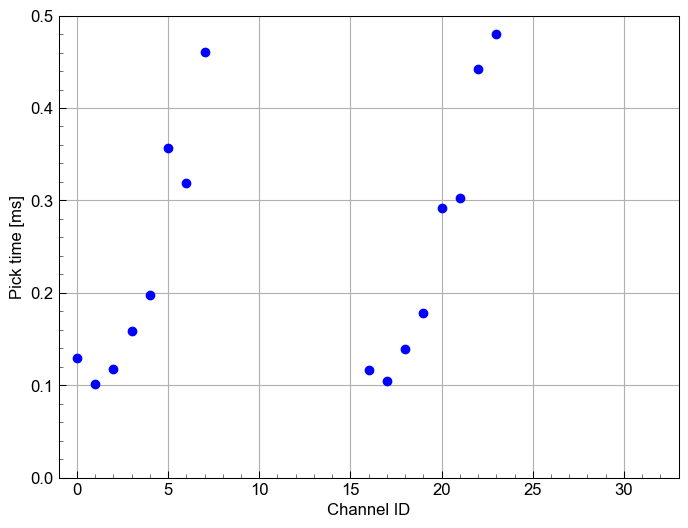

<Figure size 1000x1000 with 0 Axes>

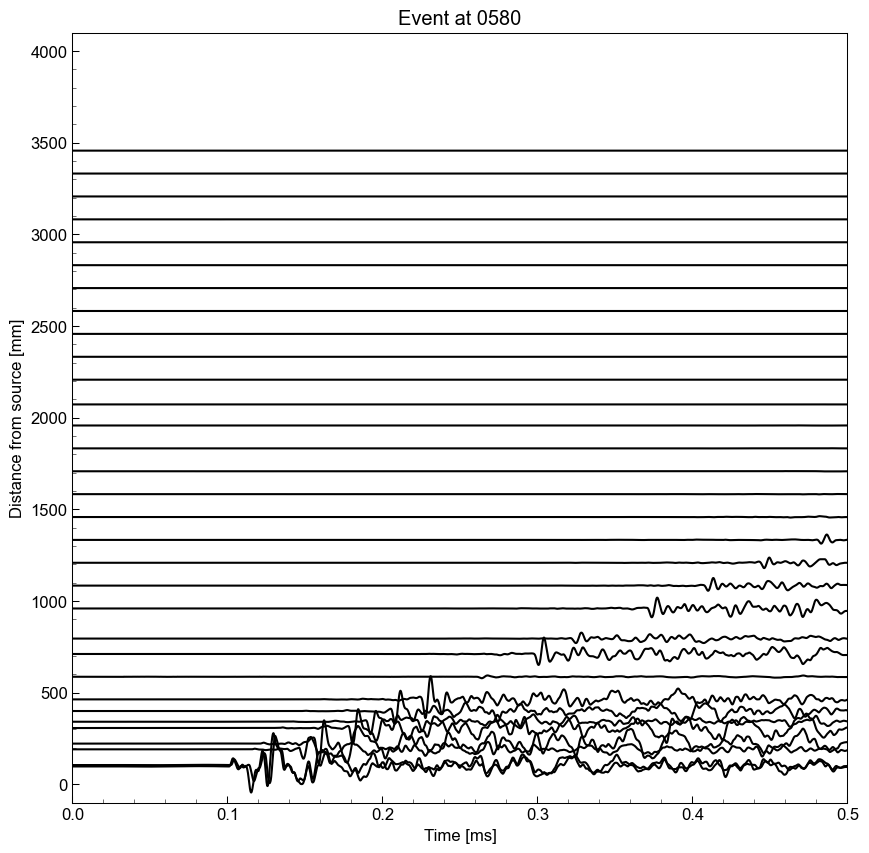

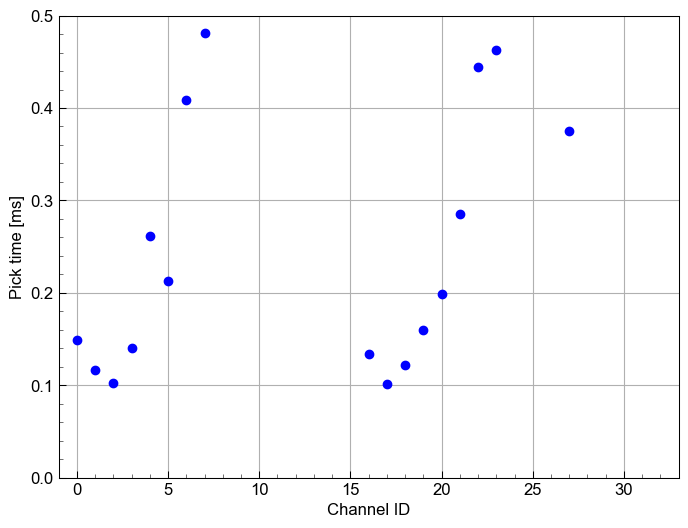

<Figure size 1000x1000 with 0 Axes>

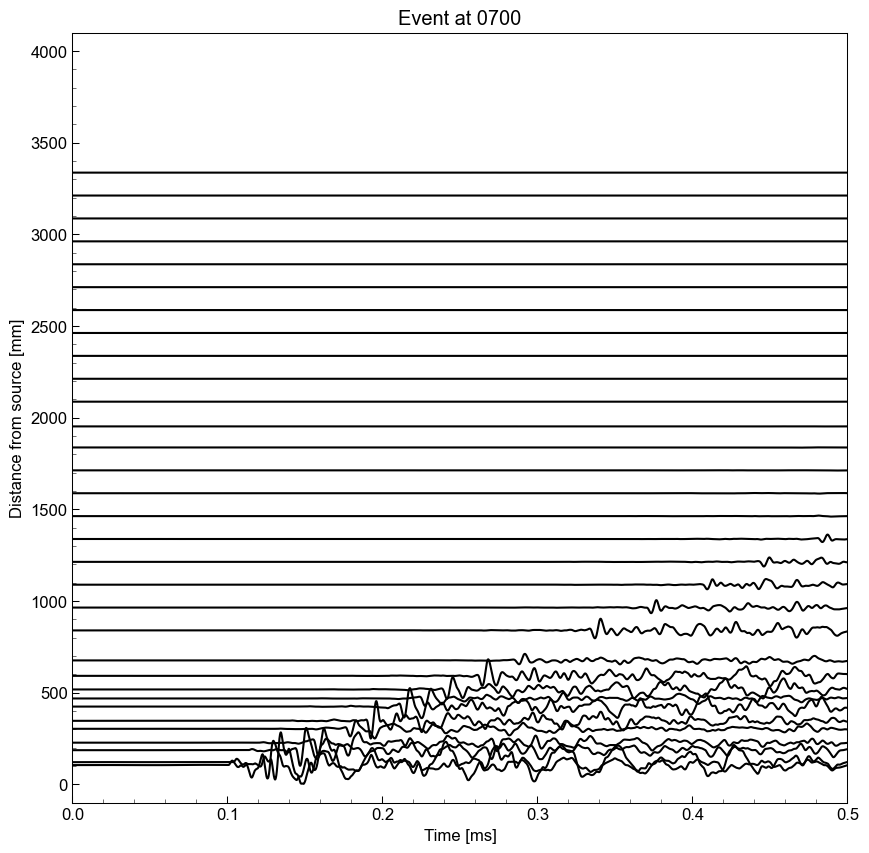

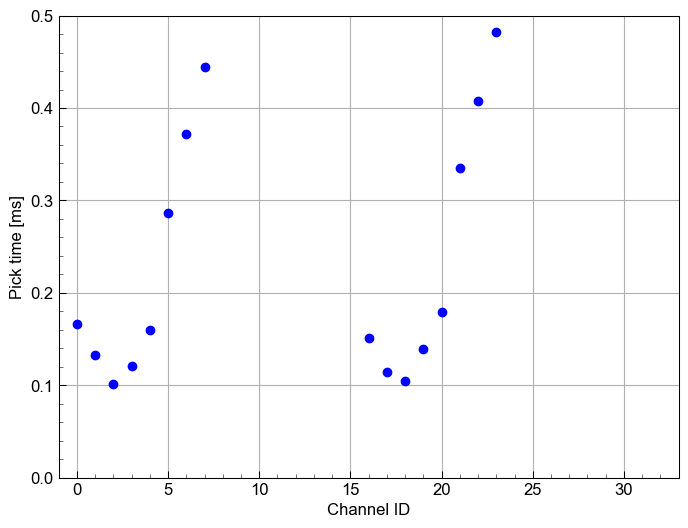

<Figure size 1000x1000 with 0 Axes>

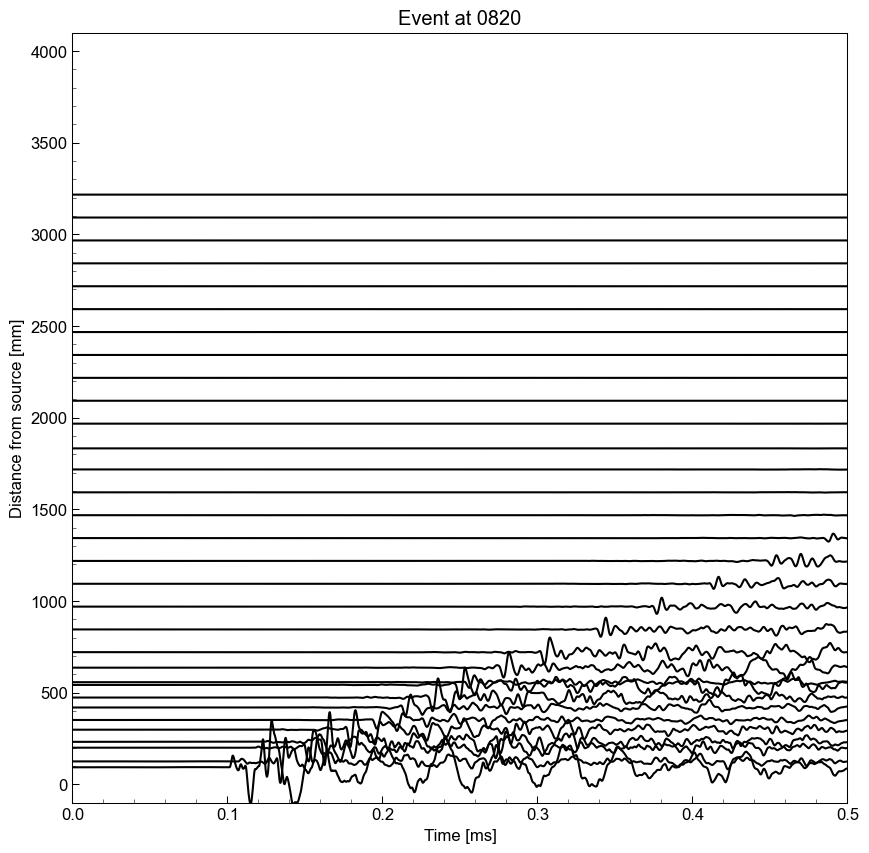

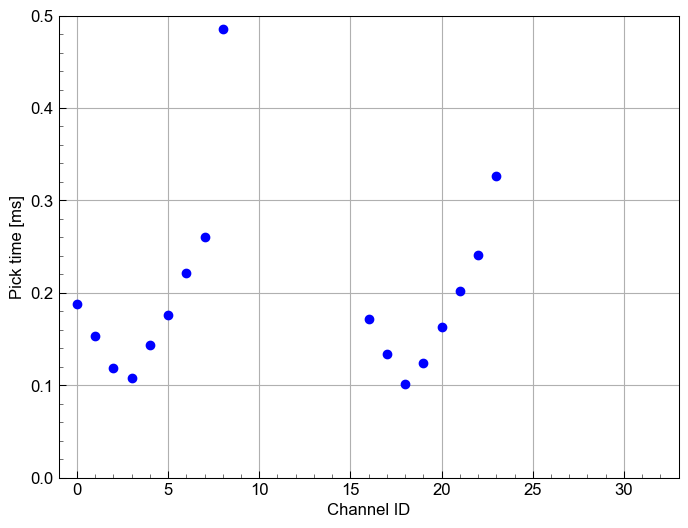

<Figure size 1000x1000 with 0 Axes>

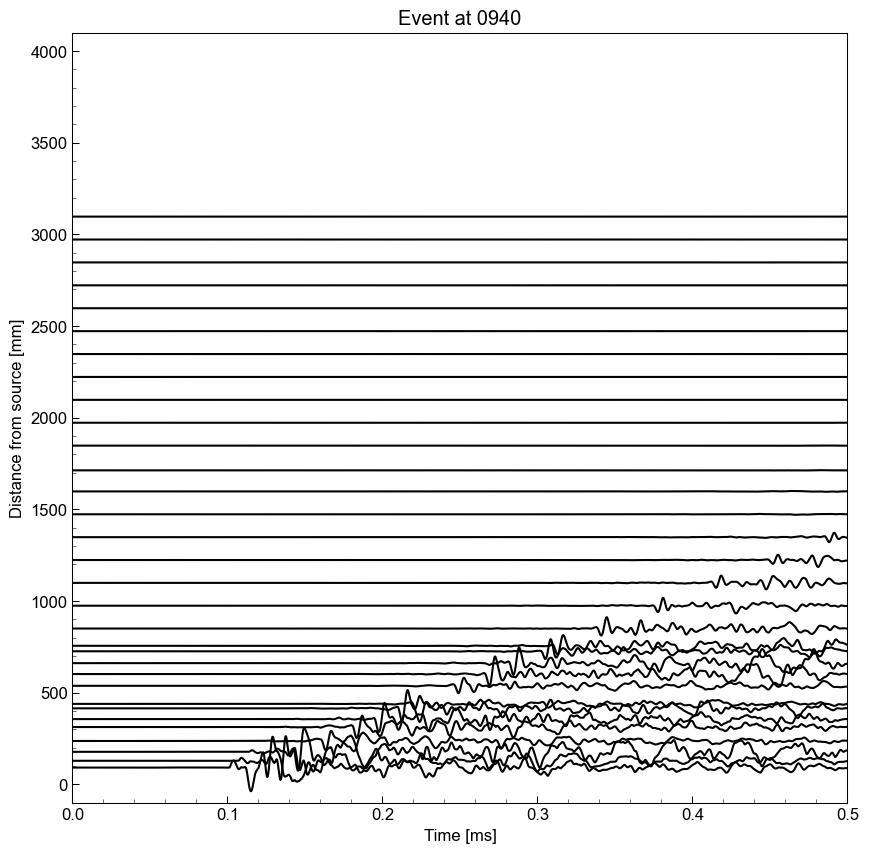

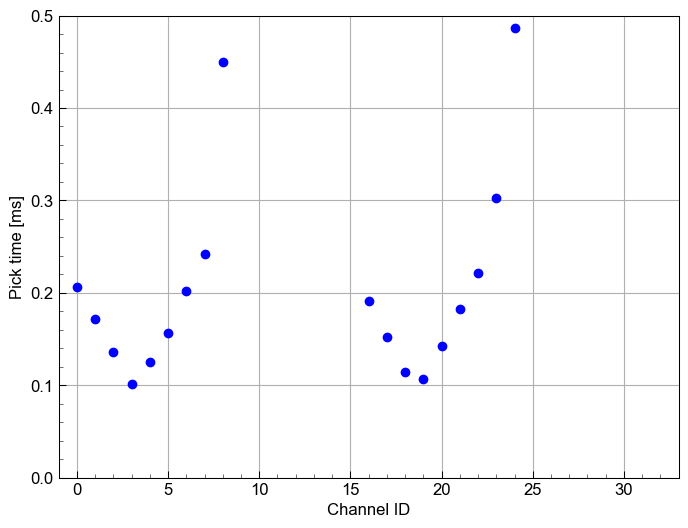

<Figure size 1000x1000 with 0 Axes>

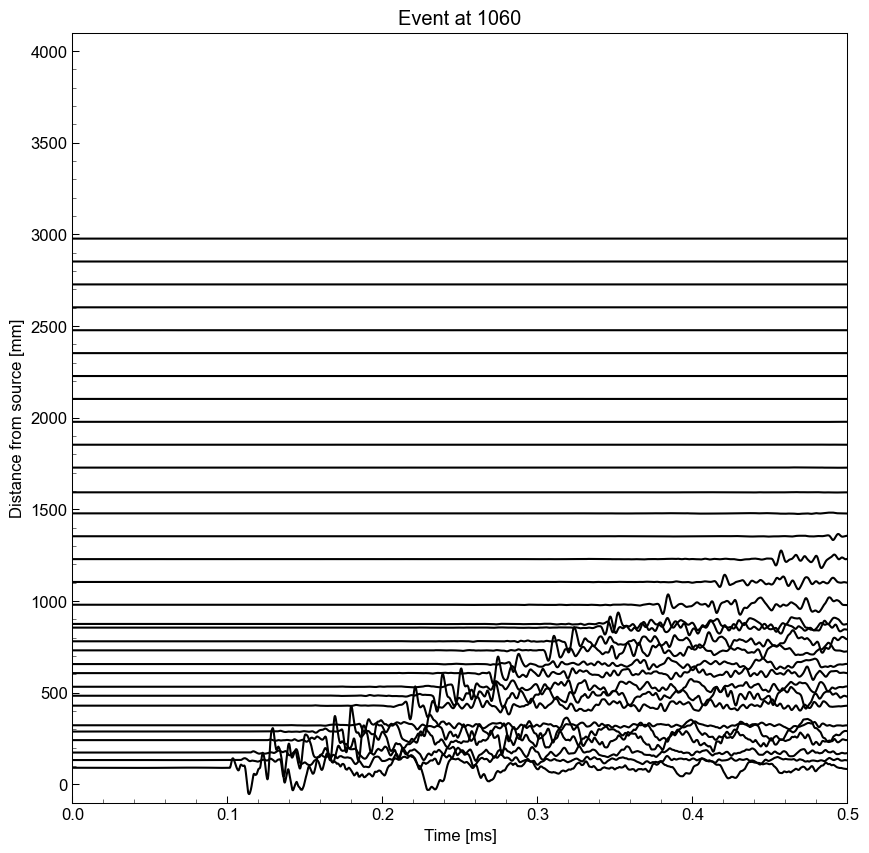

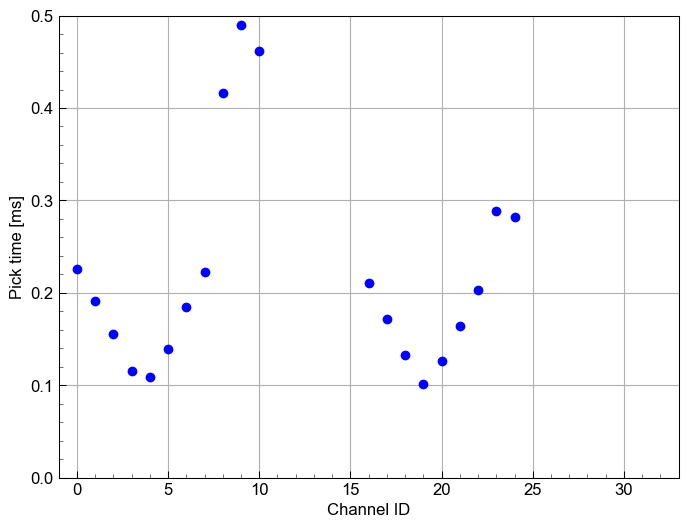

<Figure size 1000x1000 with 0 Axes>

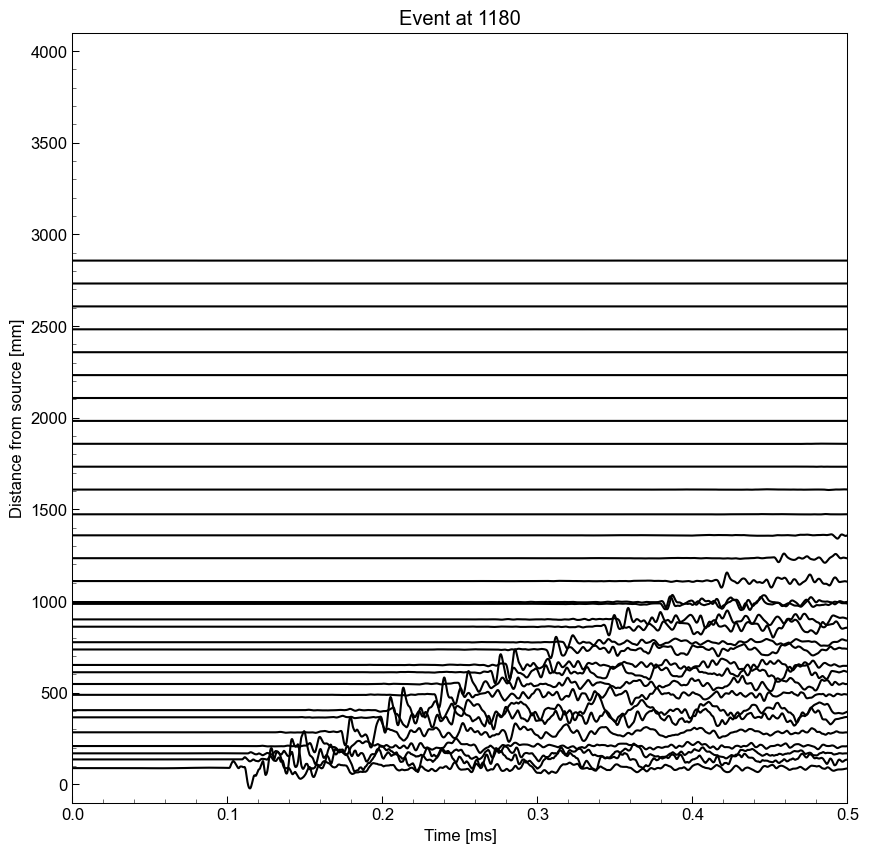

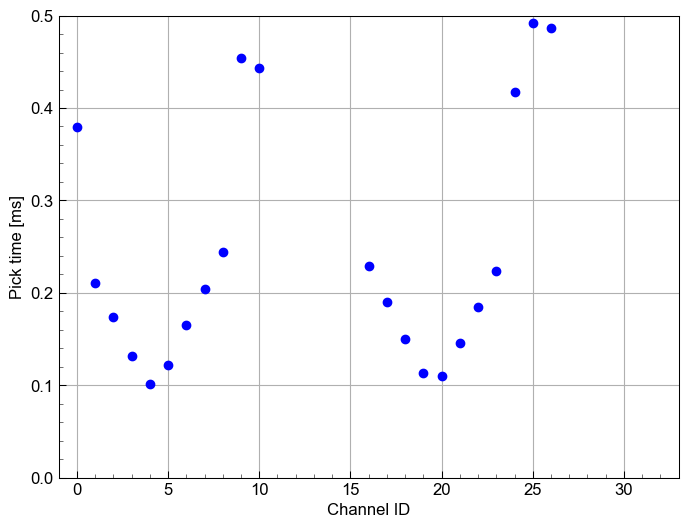

<Figure size 1000x1000 with 0 Axes>

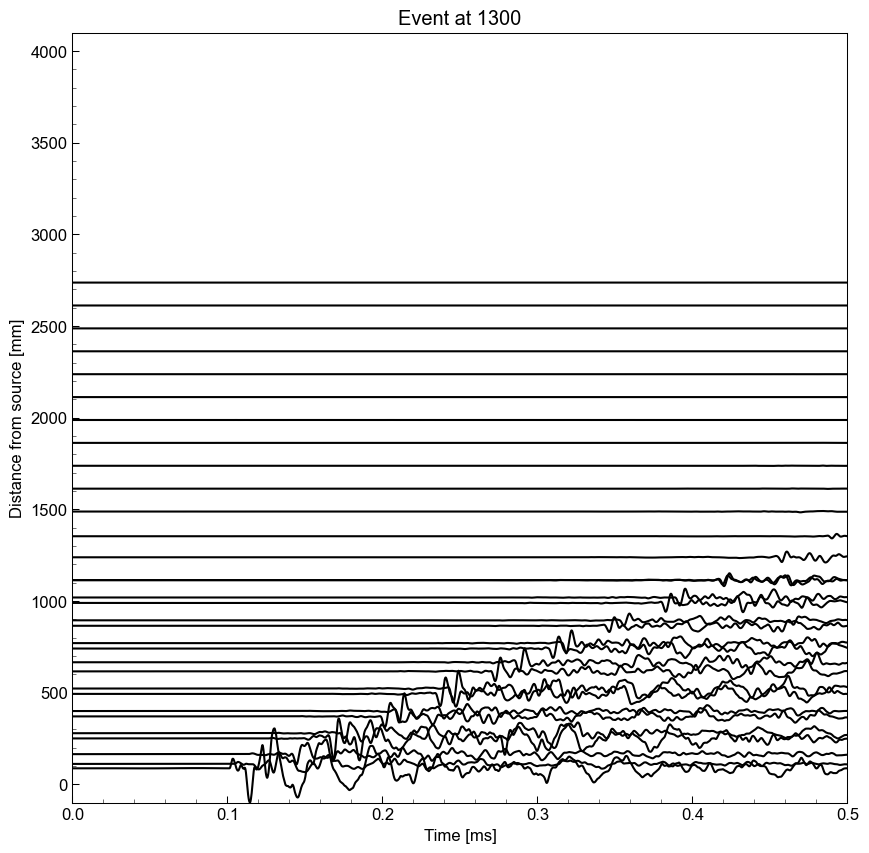

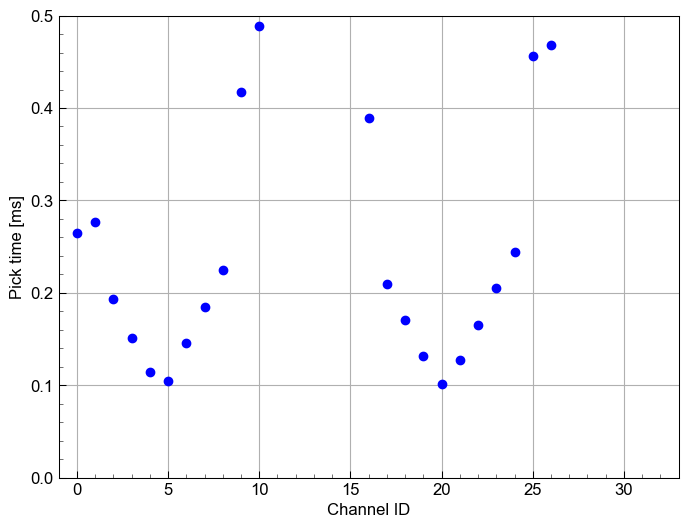

<Figure size 1000x1000 with 0 Axes>

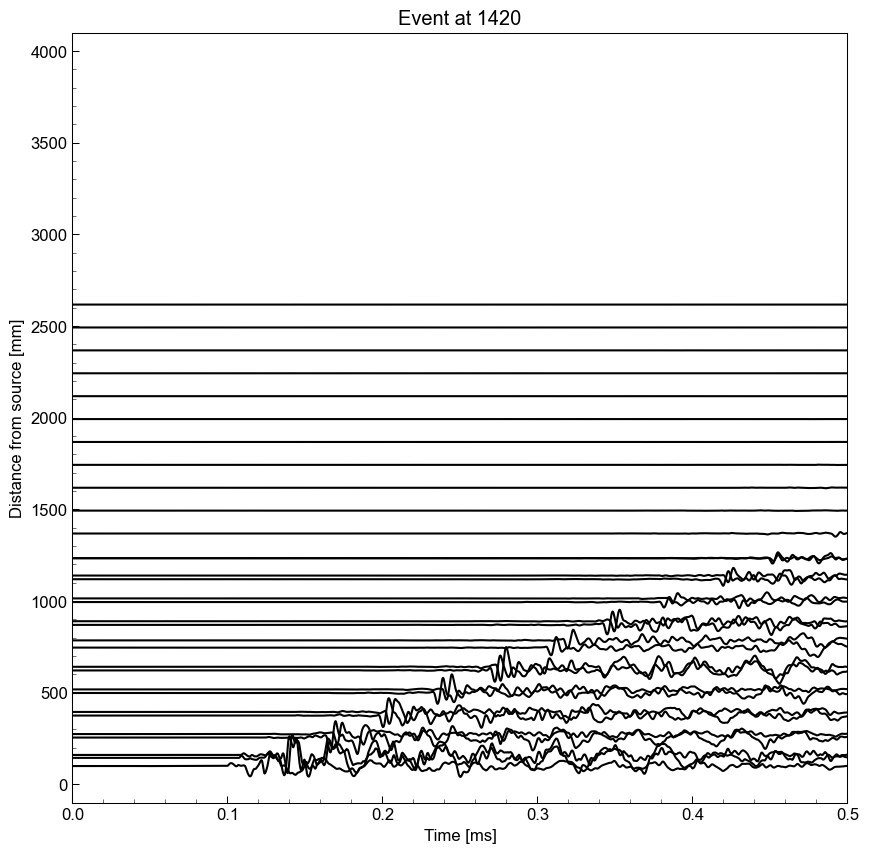

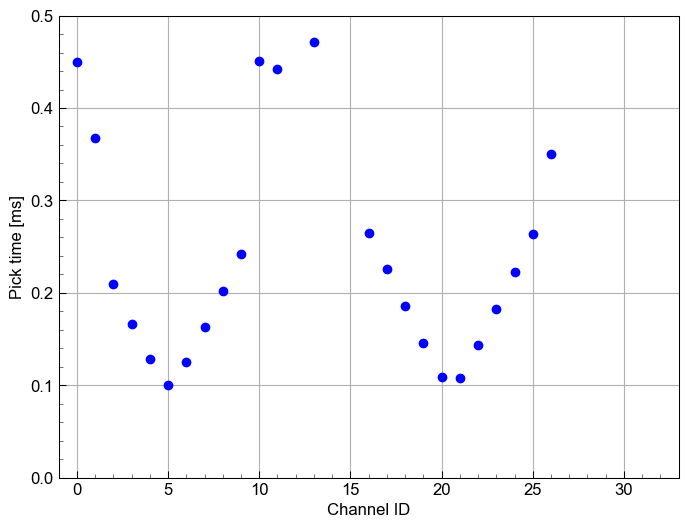

<Figure size 1000x1000 with 0 Axes>

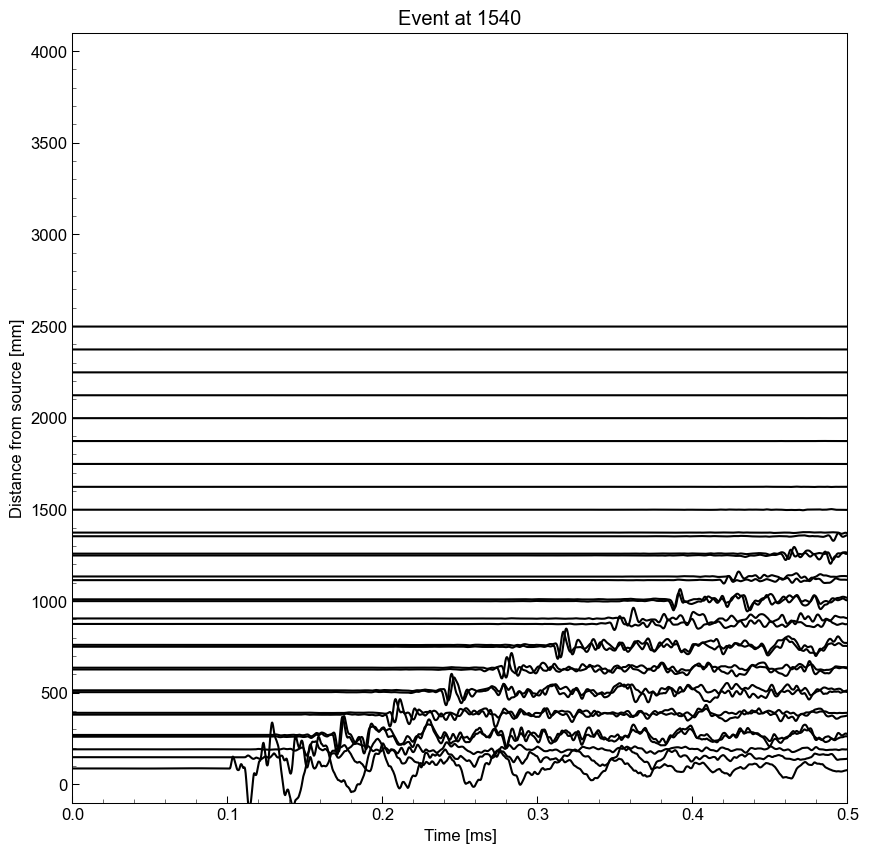

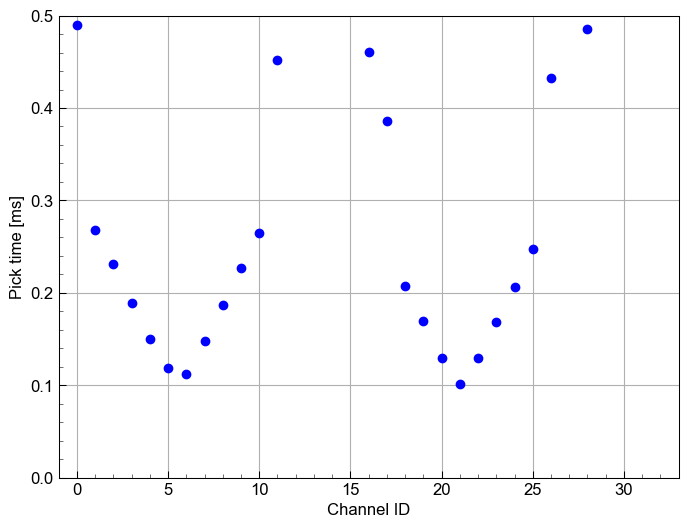

<Figure size 1000x1000 with 0 Axes>

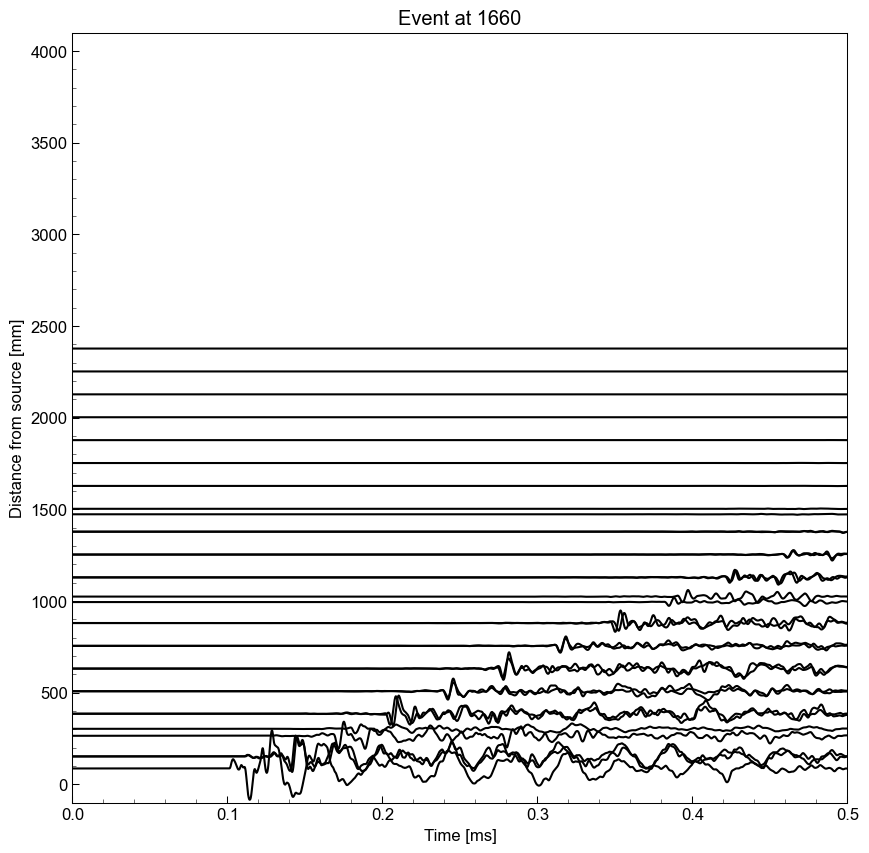

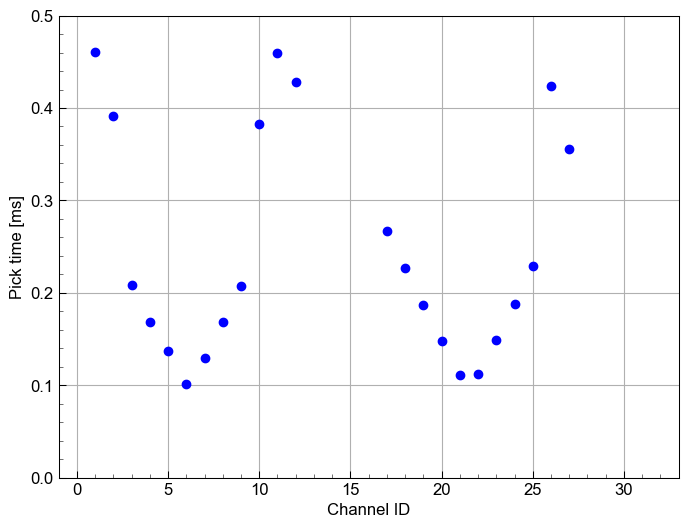

<Figure size 1000x1000 with 0 Axes>

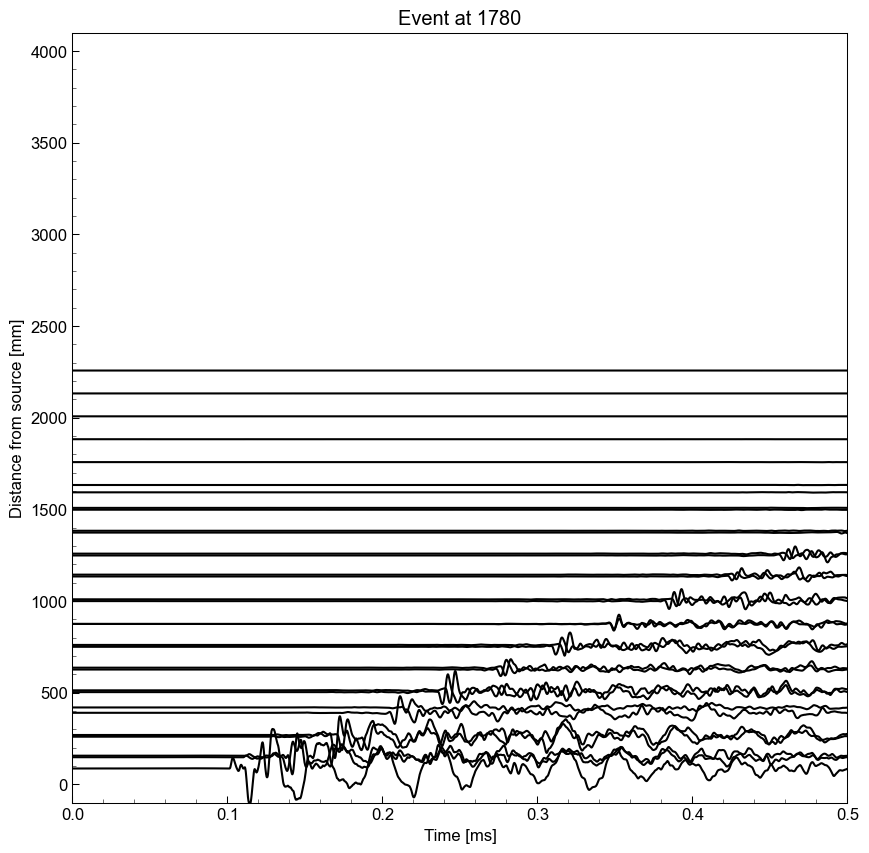

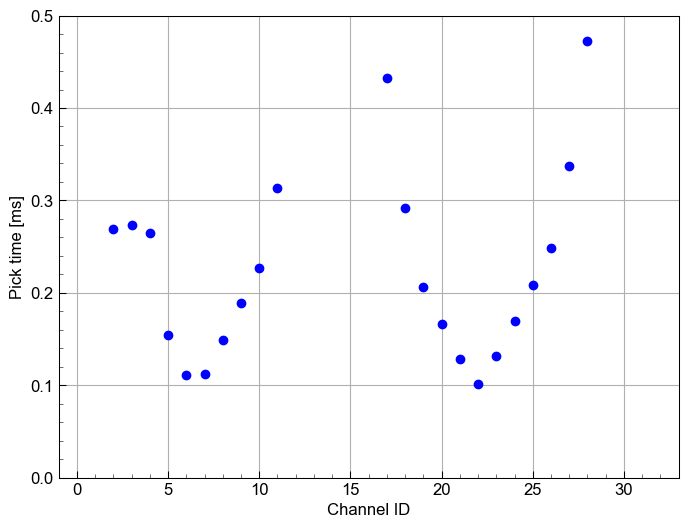

<Figure size 1000x1000 with 0 Axes>

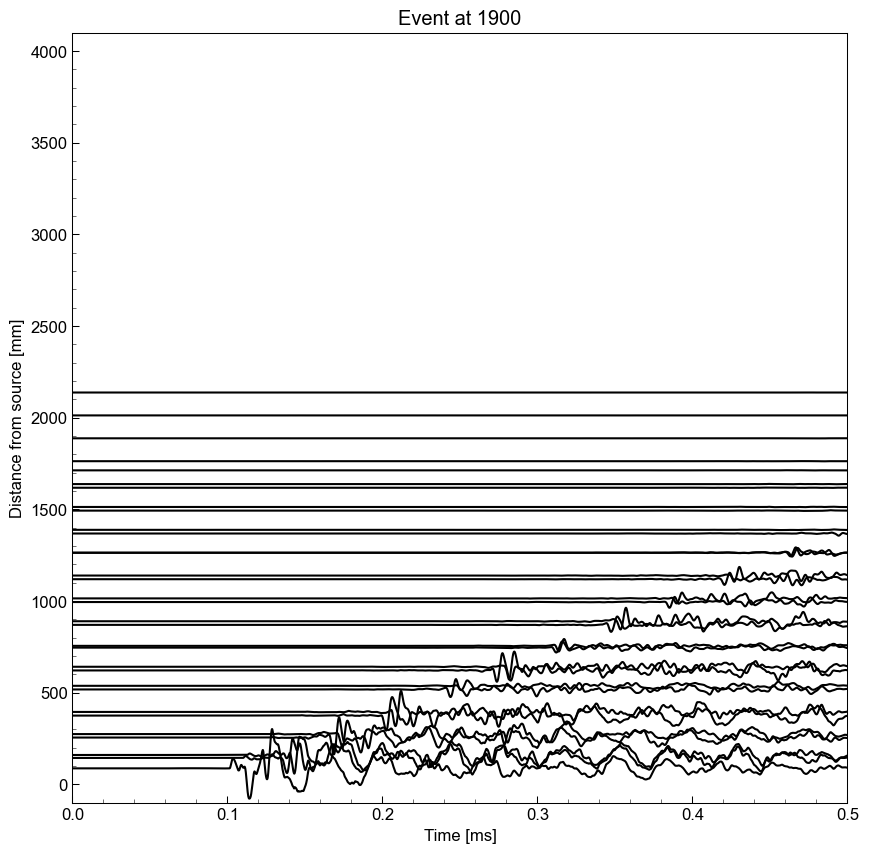

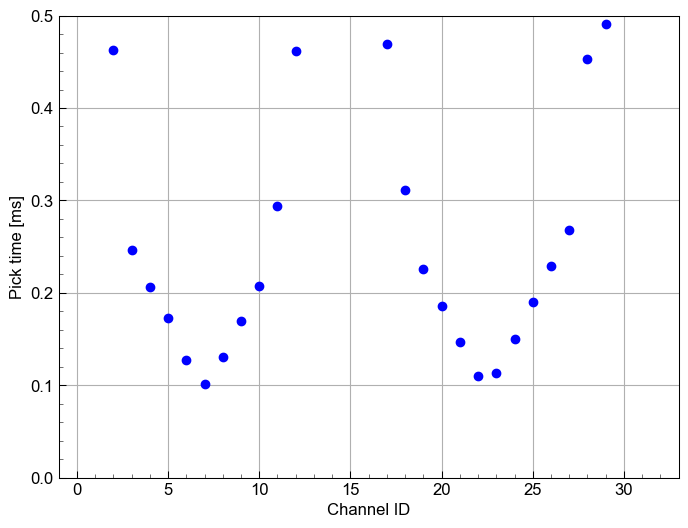

<Figure size 1000x1000 with 0 Axes>

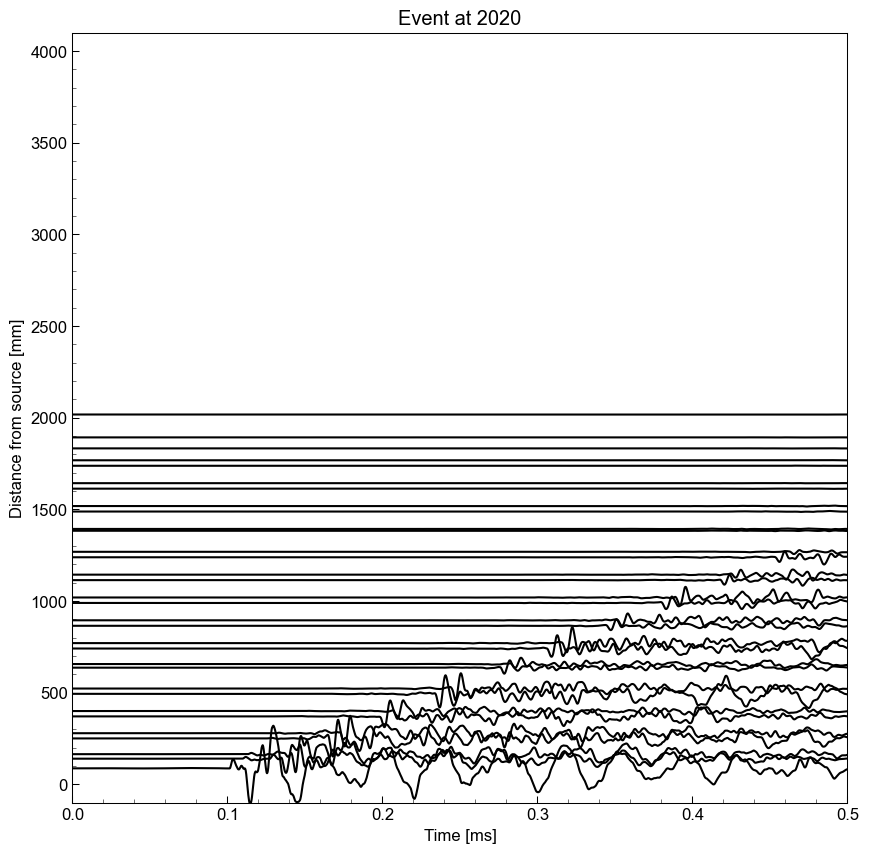

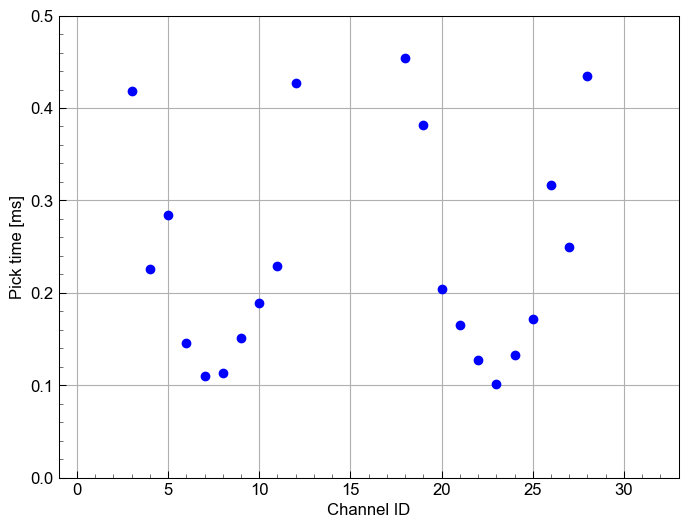

<Figure size 1000x1000 with 0 Axes>

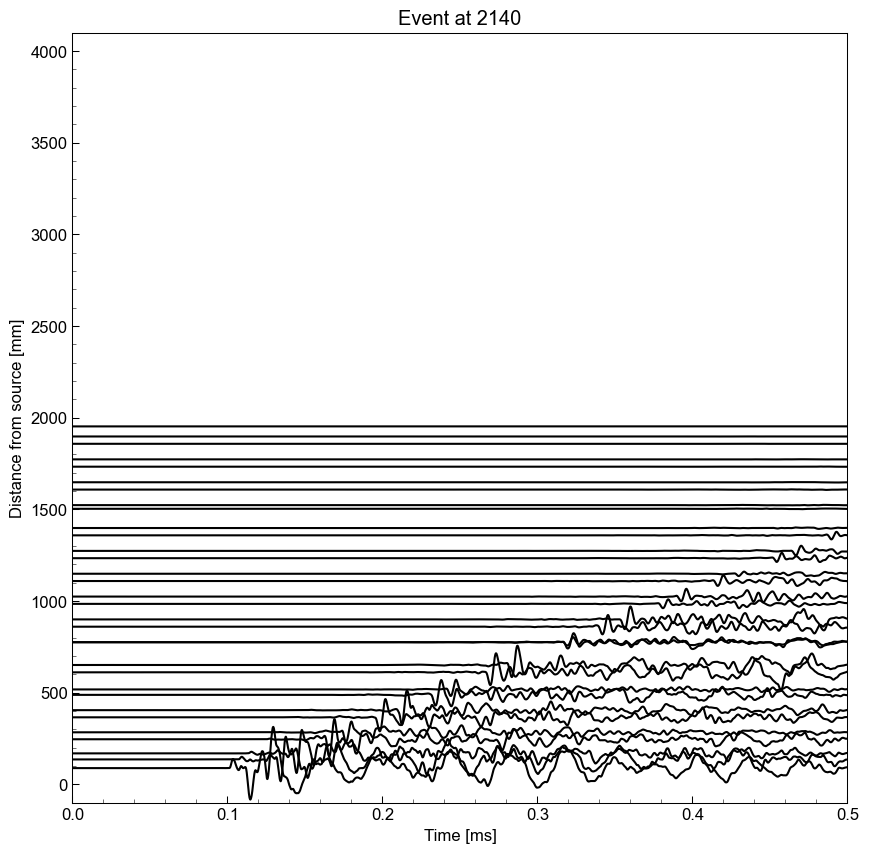

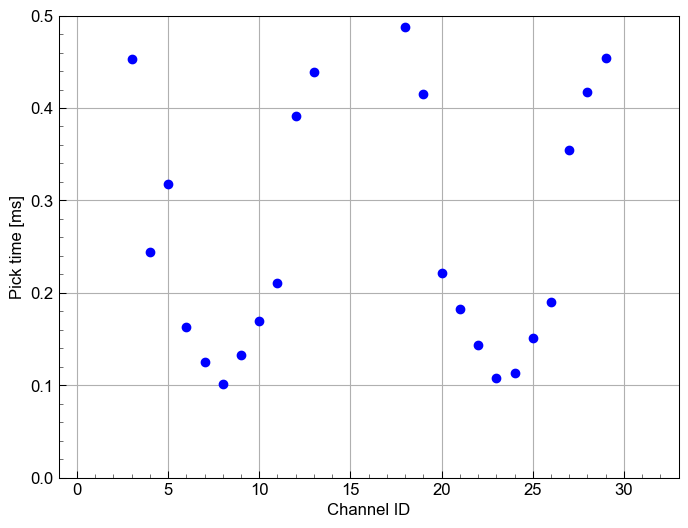

<Figure size 1000x1000 with 0 Axes>

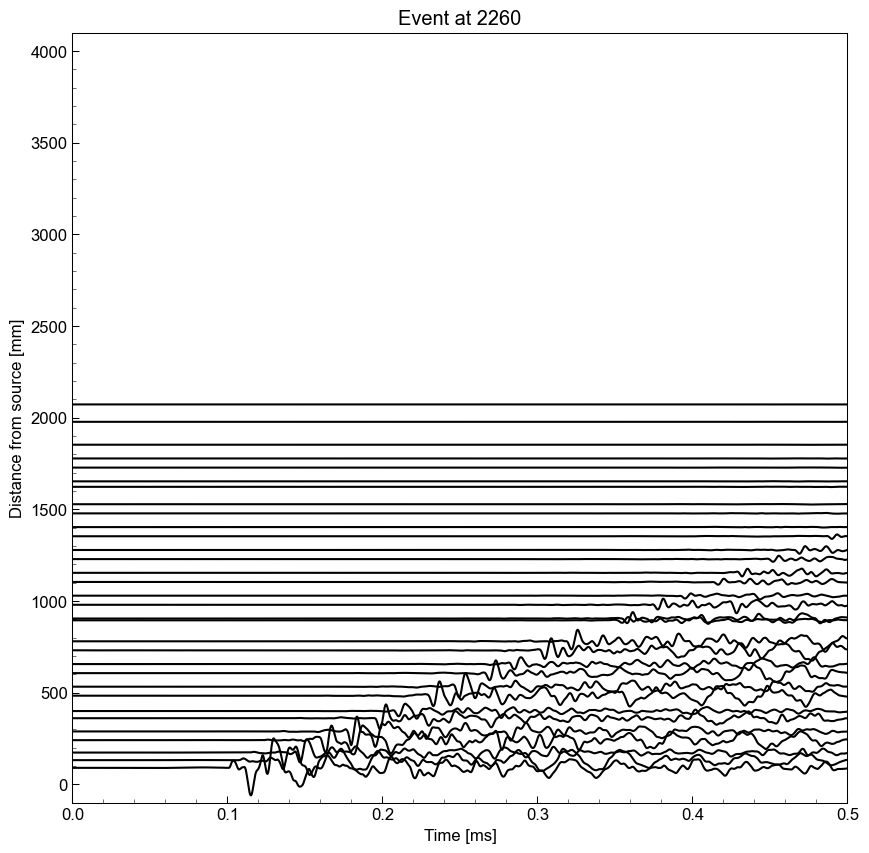

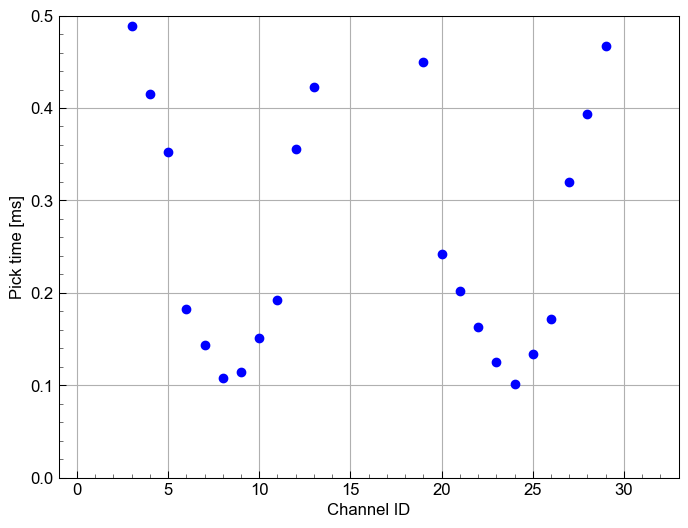

<Figure size 1000x1000 with 0 Axes>

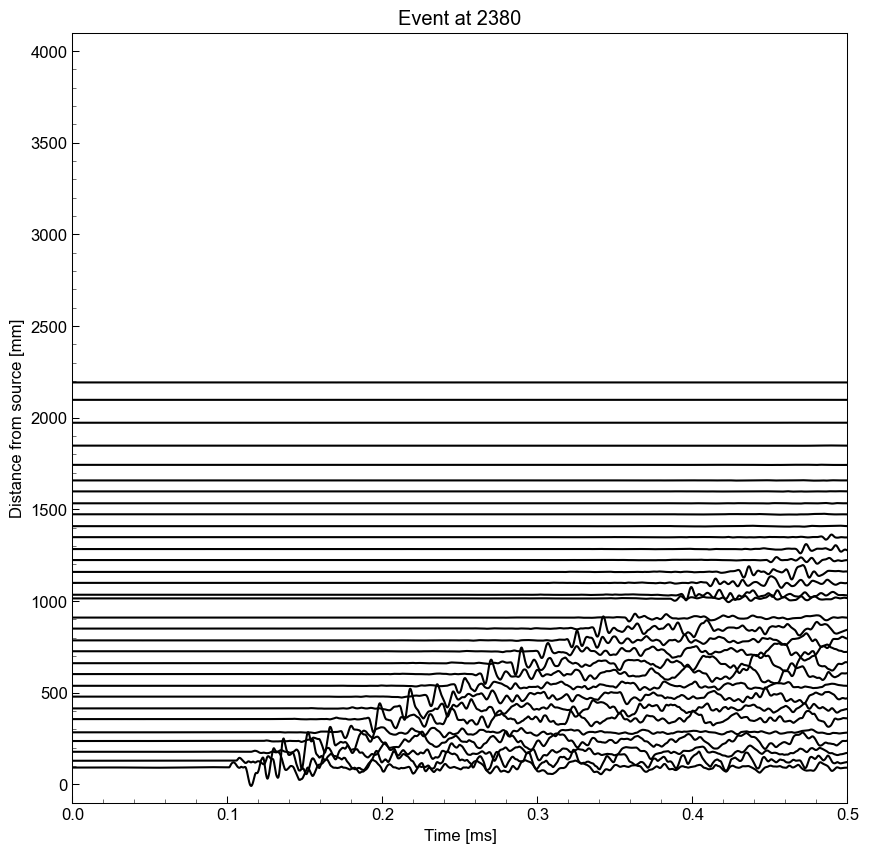

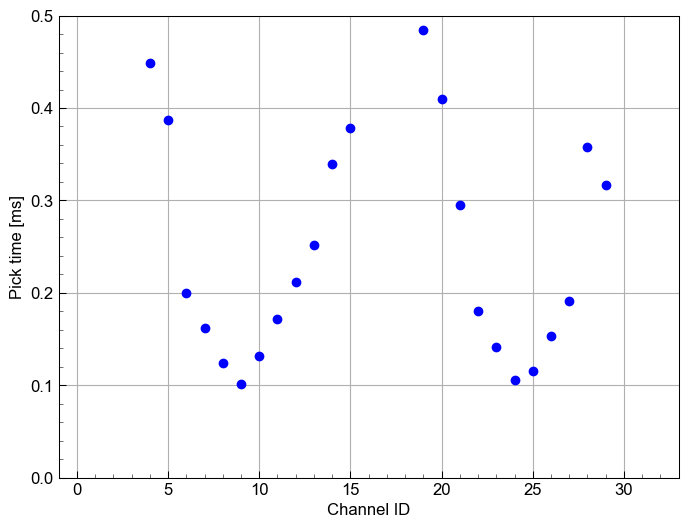

<Figure size 1000x1000 with 0 Axes>

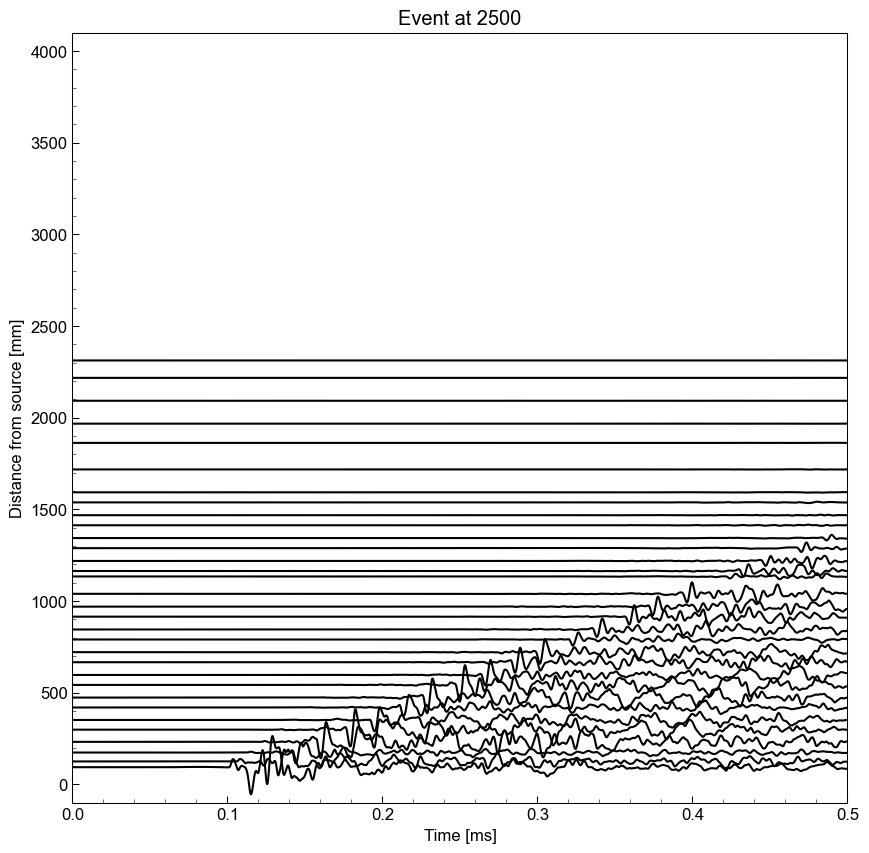

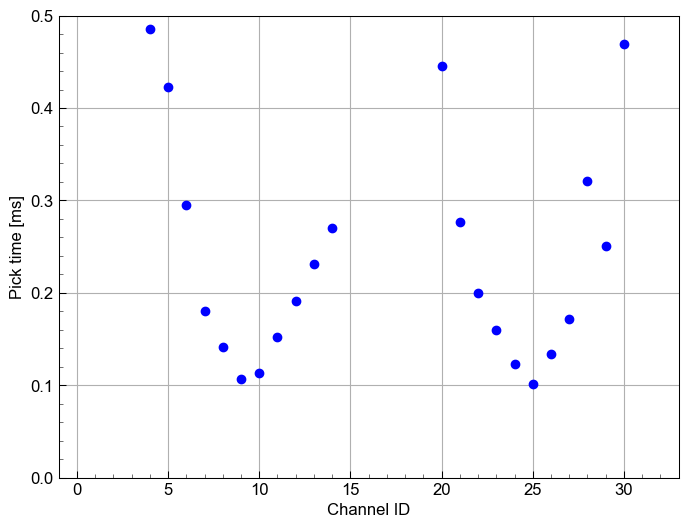

<Figure size 1000x1000 with 0 Axes>

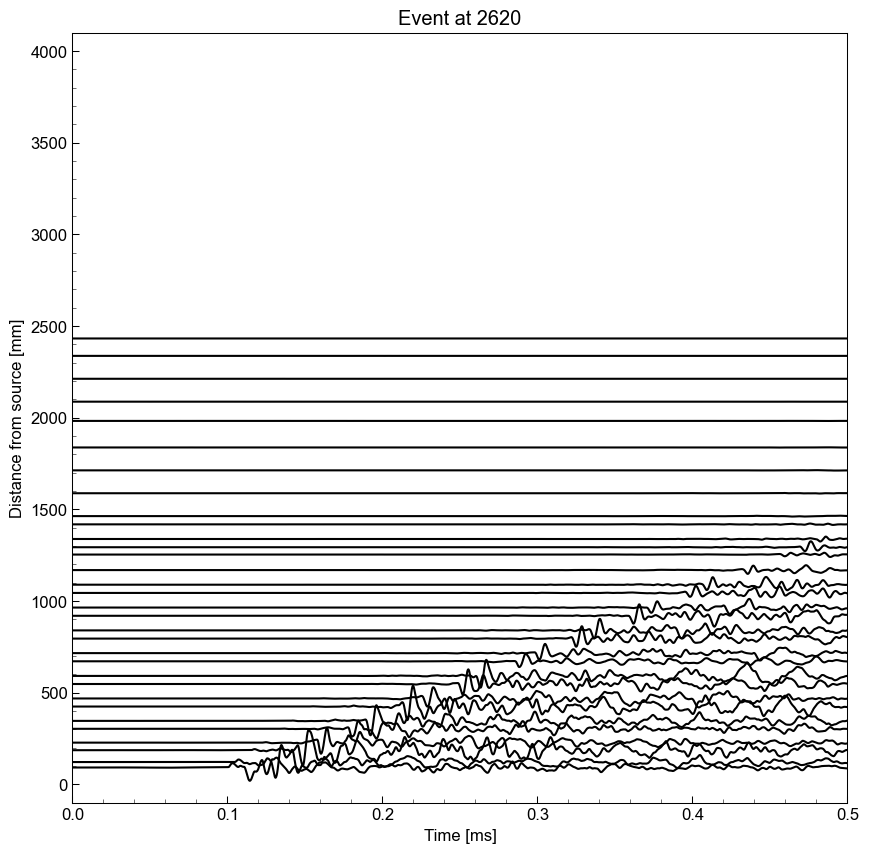

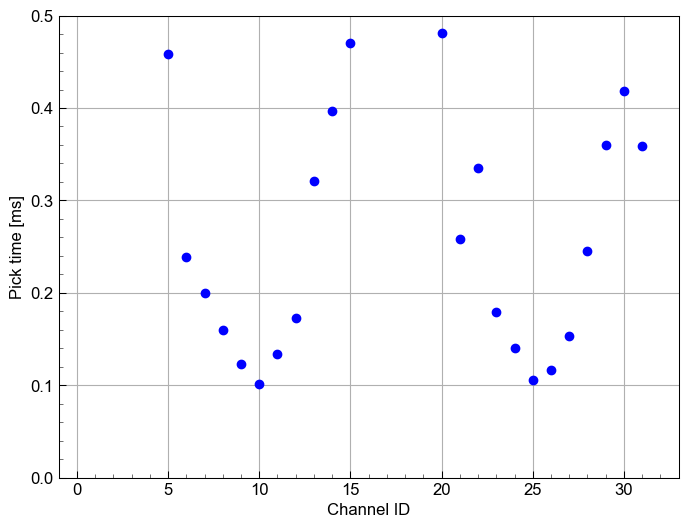

<Figure size 1000x1000 with 0 Axes>

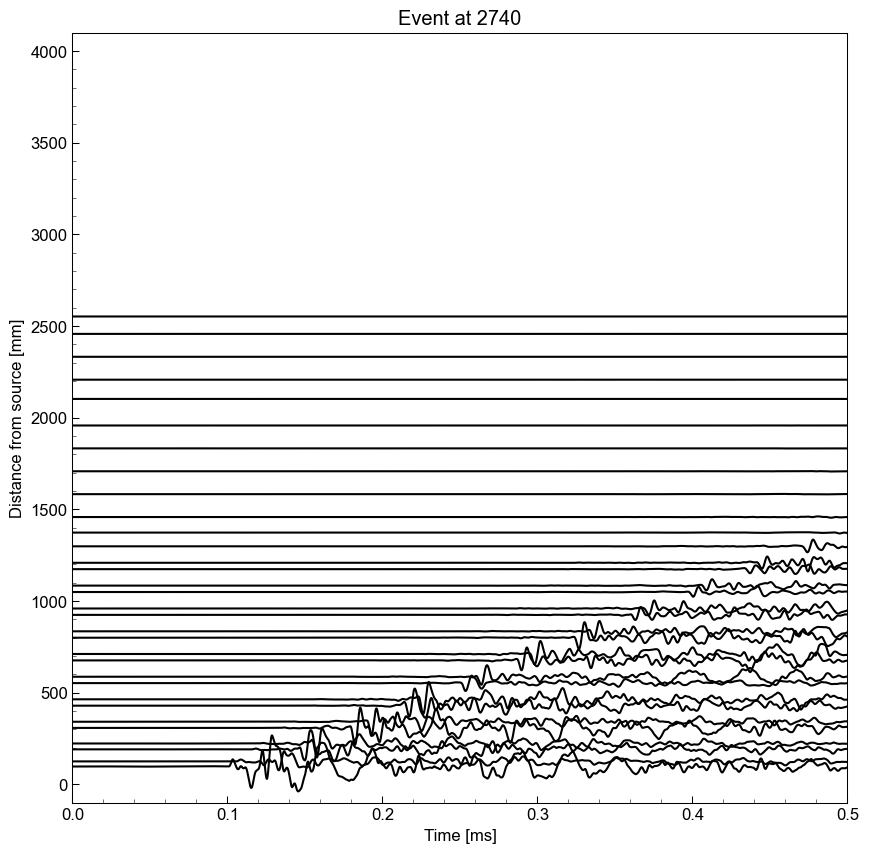

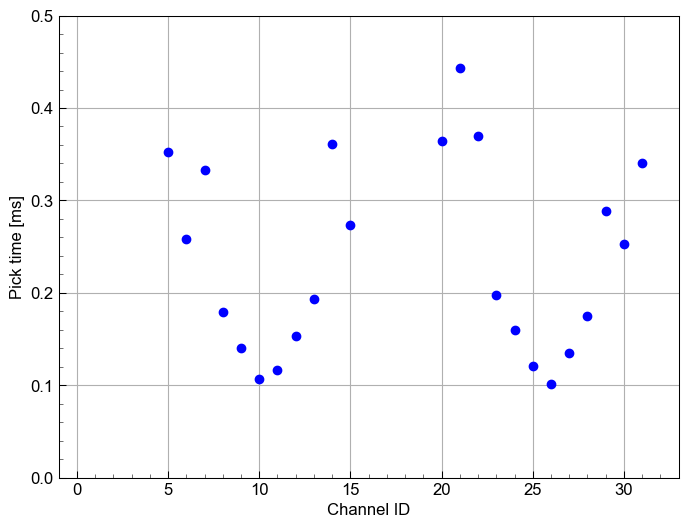

<Figure size 1000x1000 with 0 Axes>

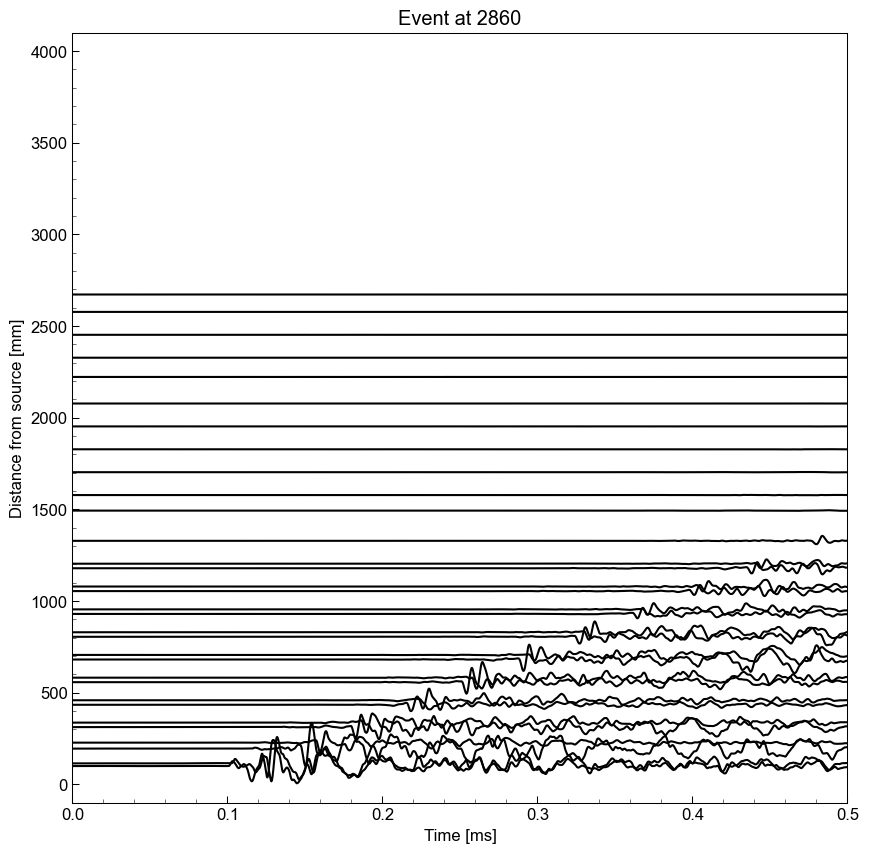

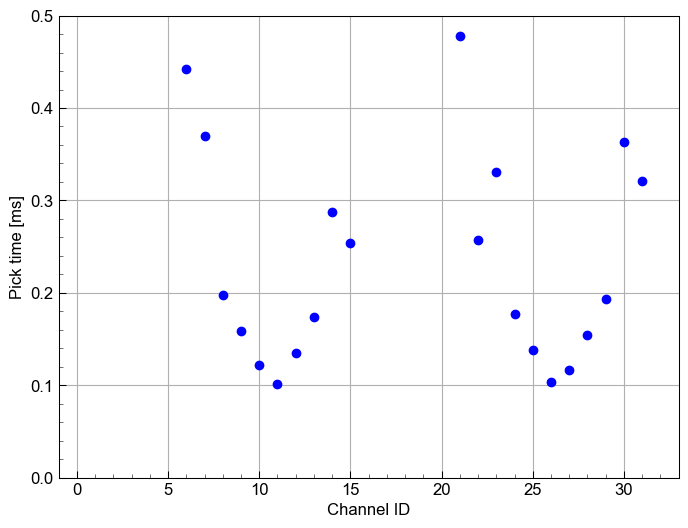

<Figure size 1000x1000 with 0 Axes>

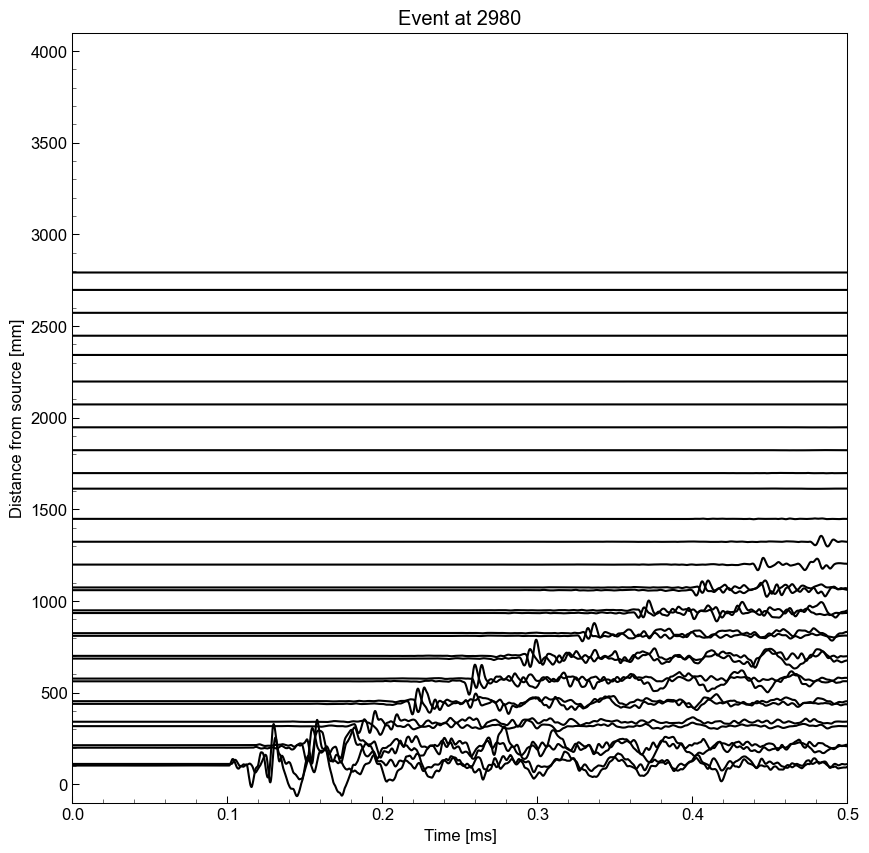

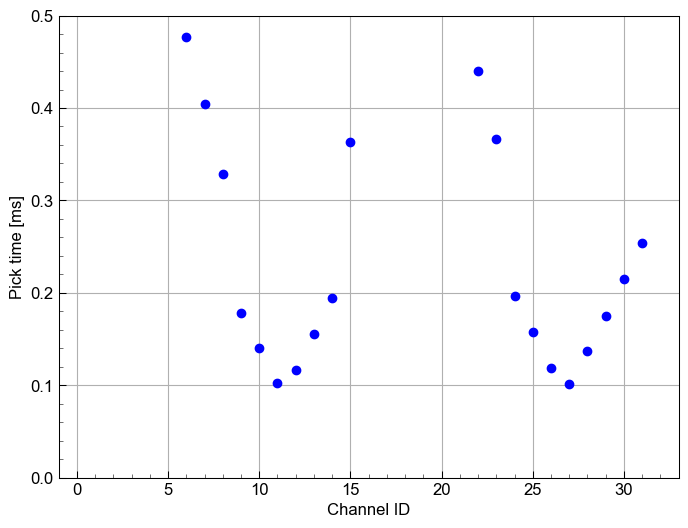

<Figure size 1000x1000 with 0 Axes>

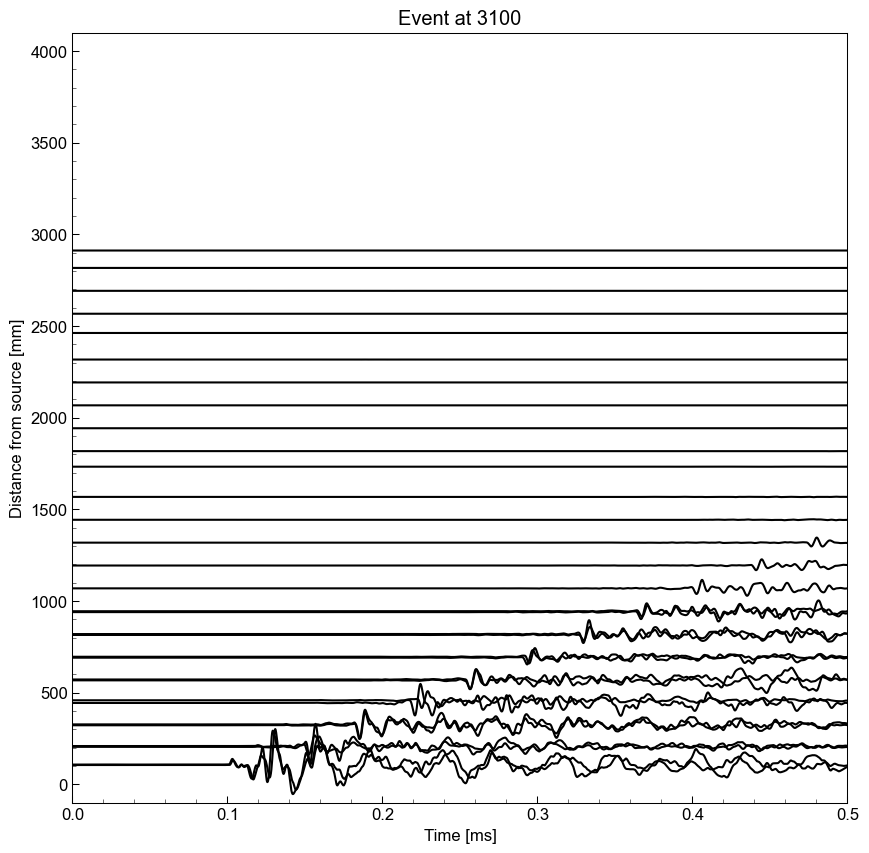

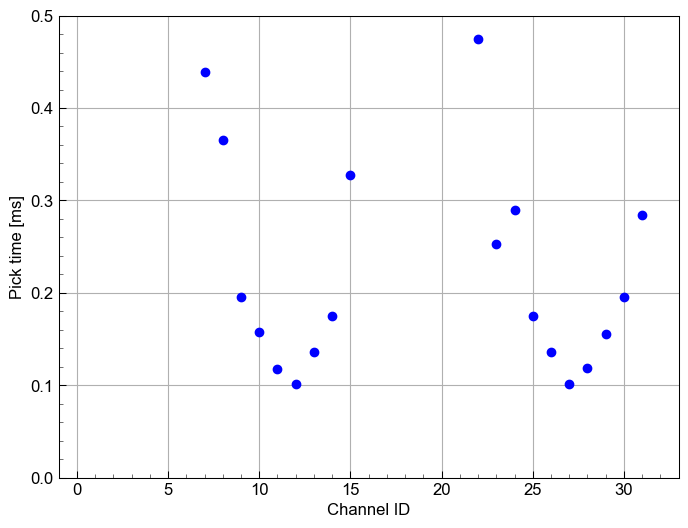

<Figure size 1000x1000 with 0 Axes>

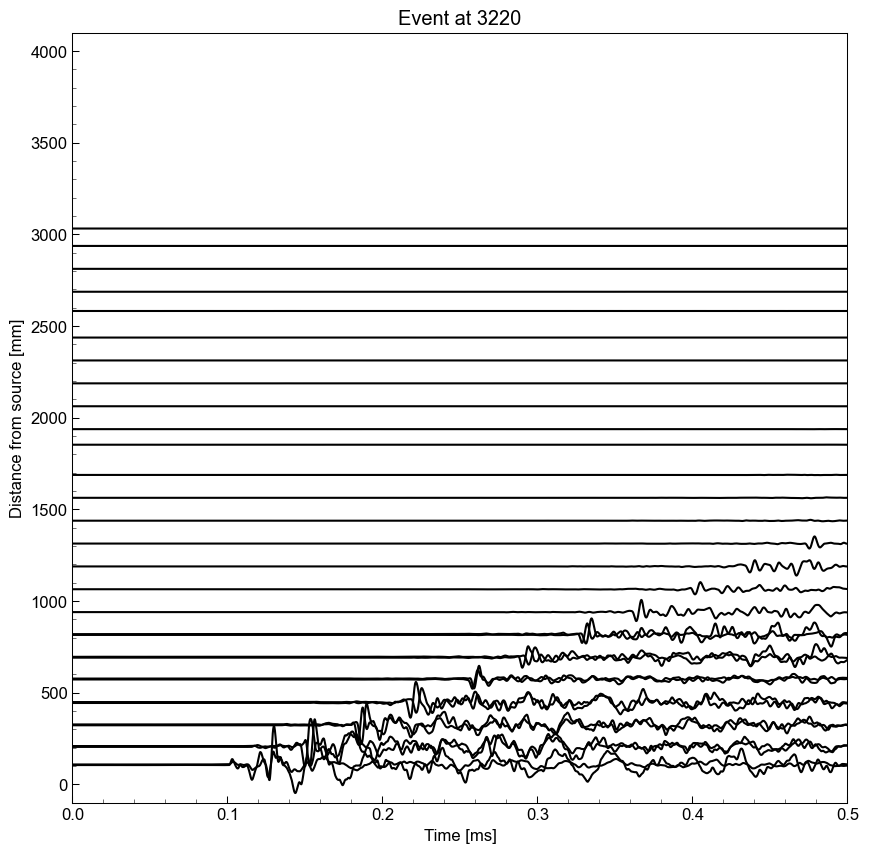

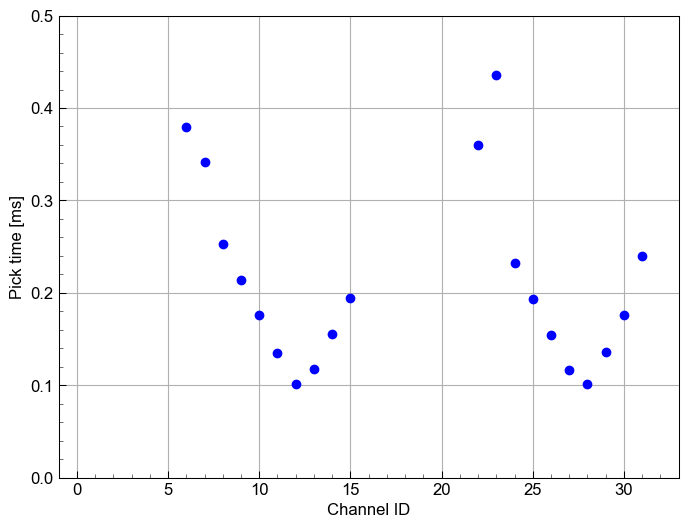

<Figure size 1000x1000 with 0 Axes>

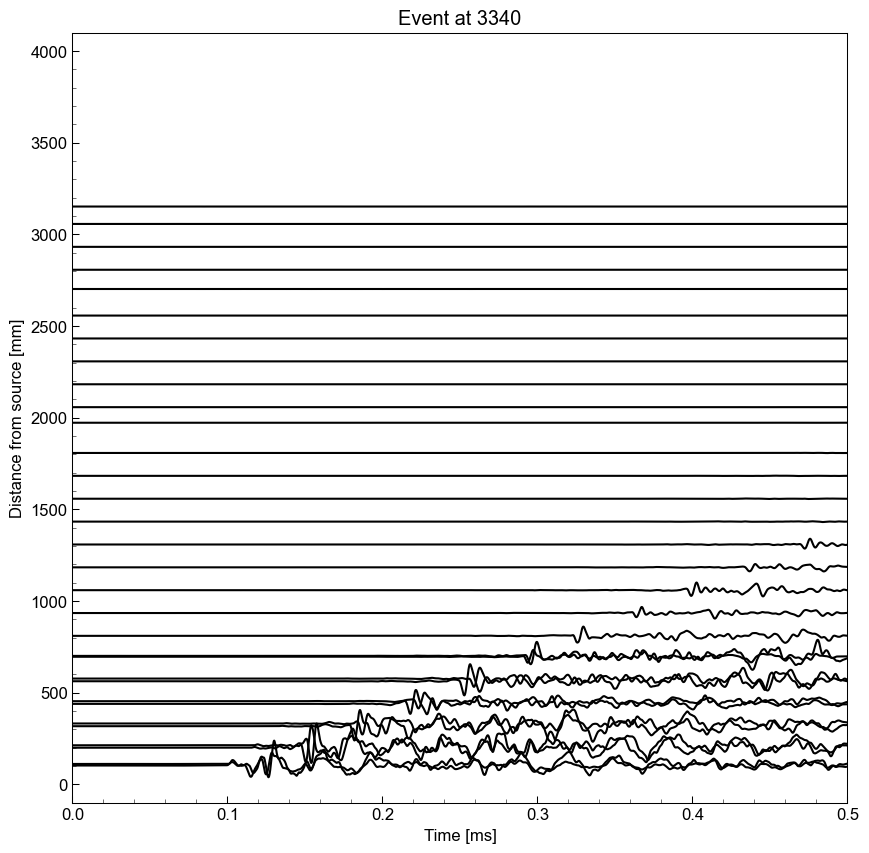

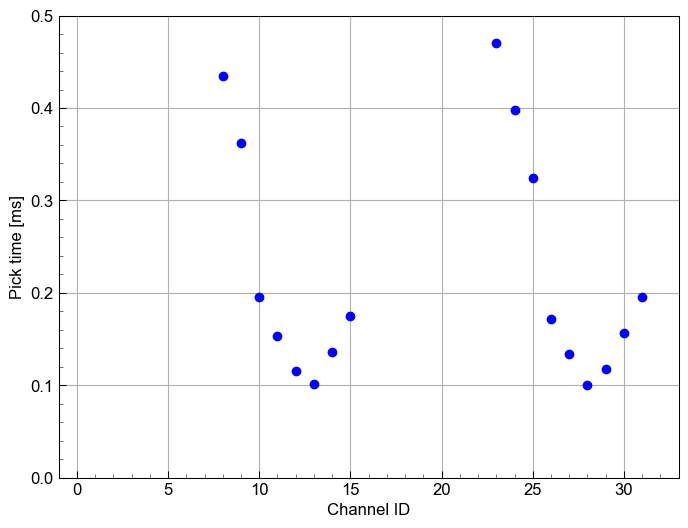

<Figure size 1000x1000 with 0 Axes>

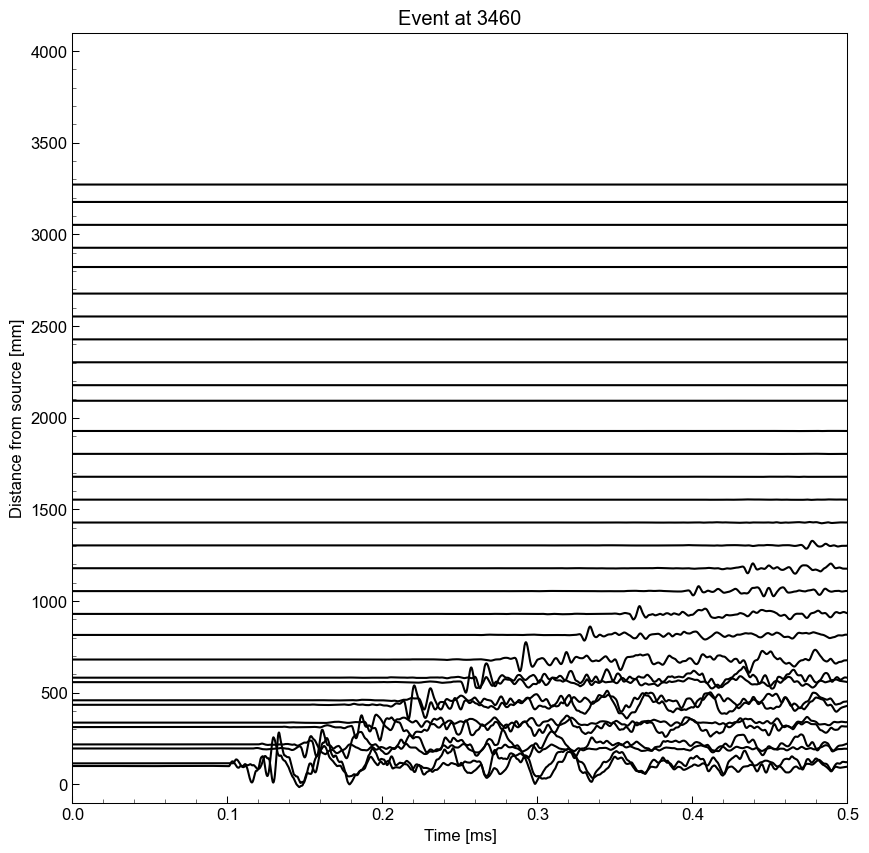

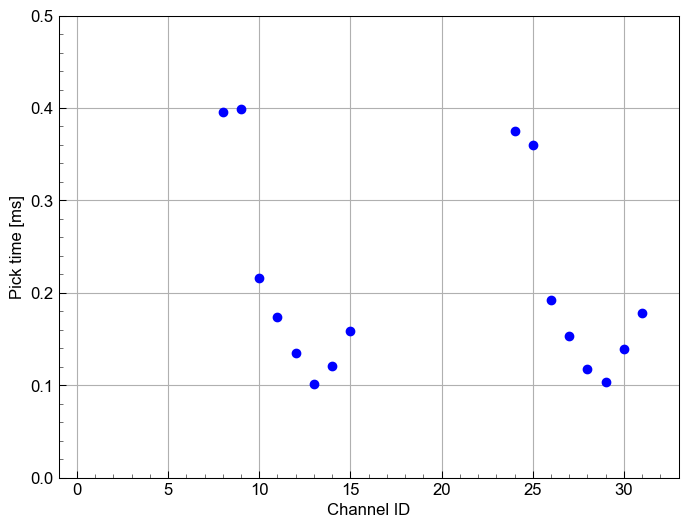

<Figure size 1000x1000 with 0 Axes>

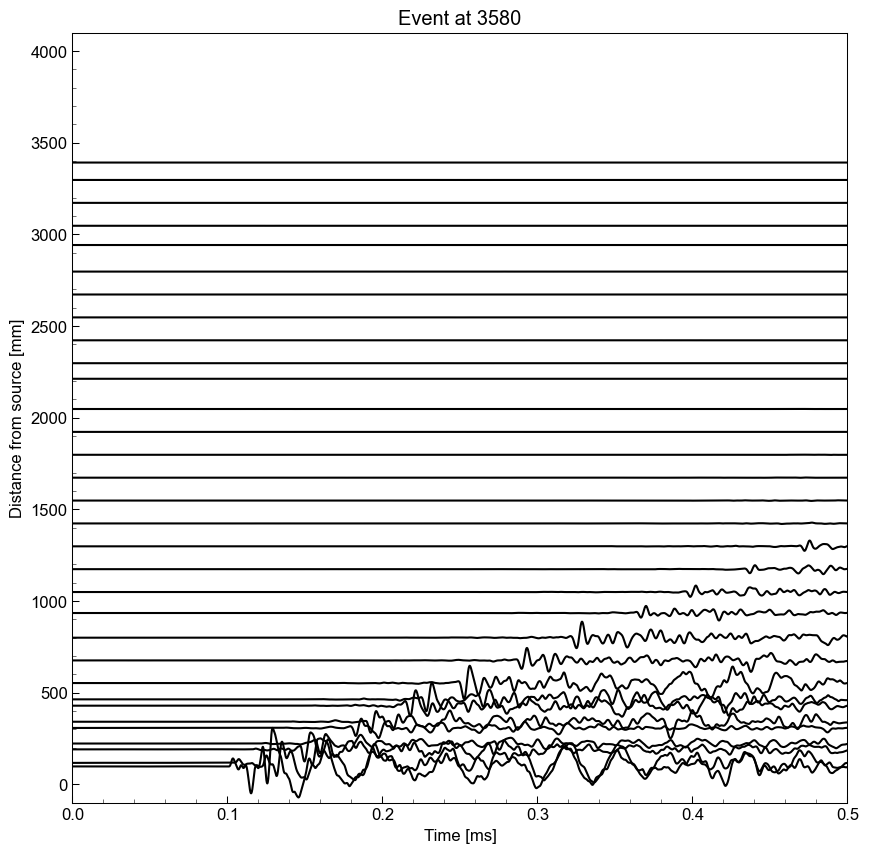

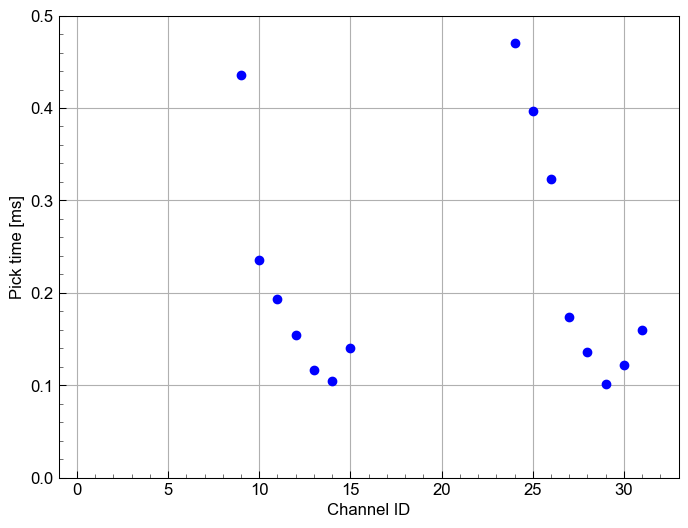

<Figure size 1000x1000 with 0 Axes>

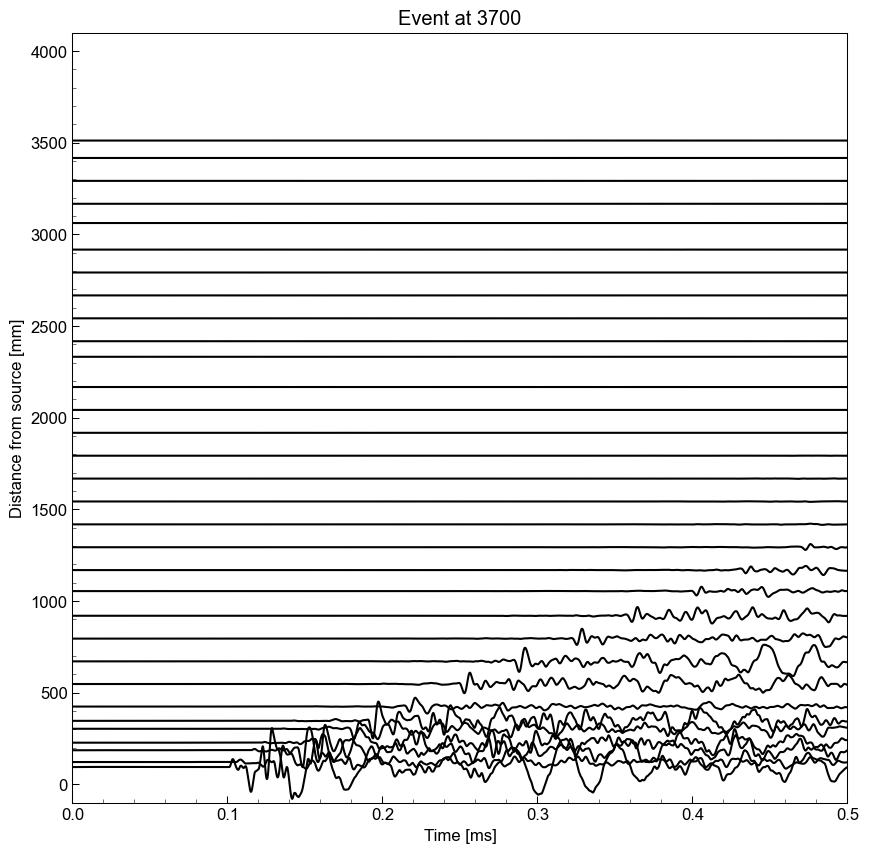

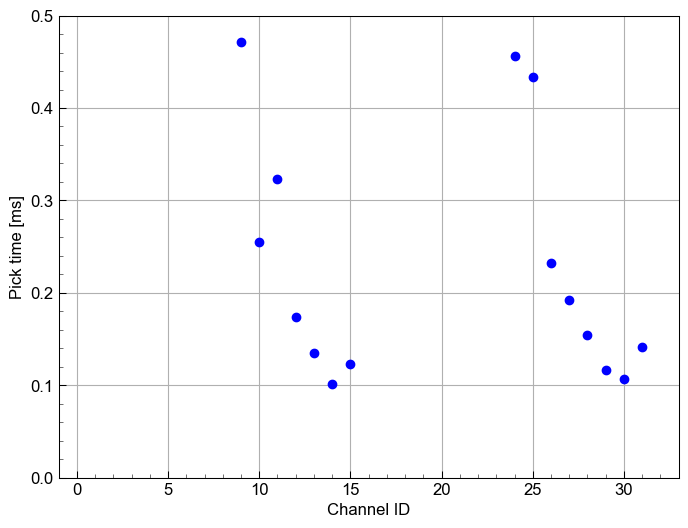

<Figure size 1000x1000 with 0 Axes>

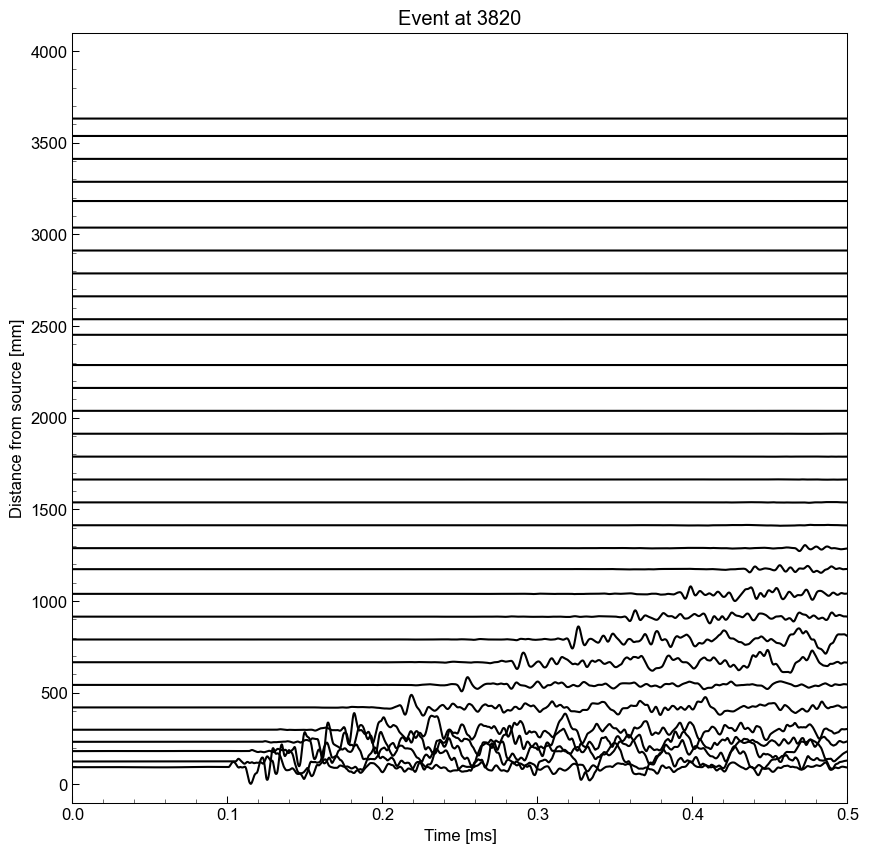

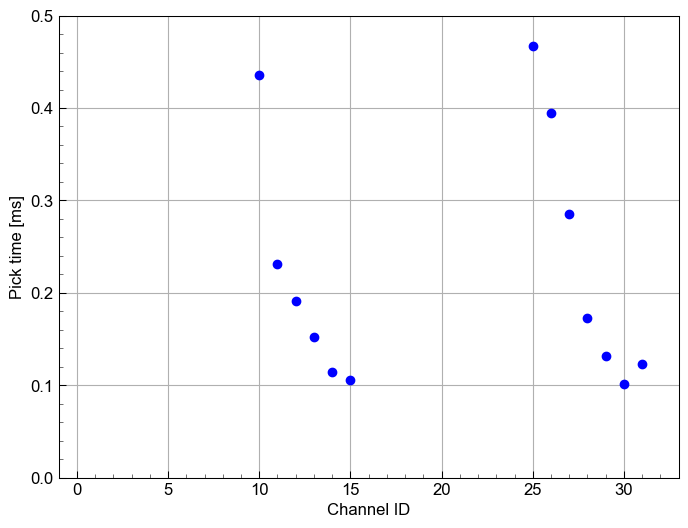

<Figure size 1000x1000 with 0 Axes>

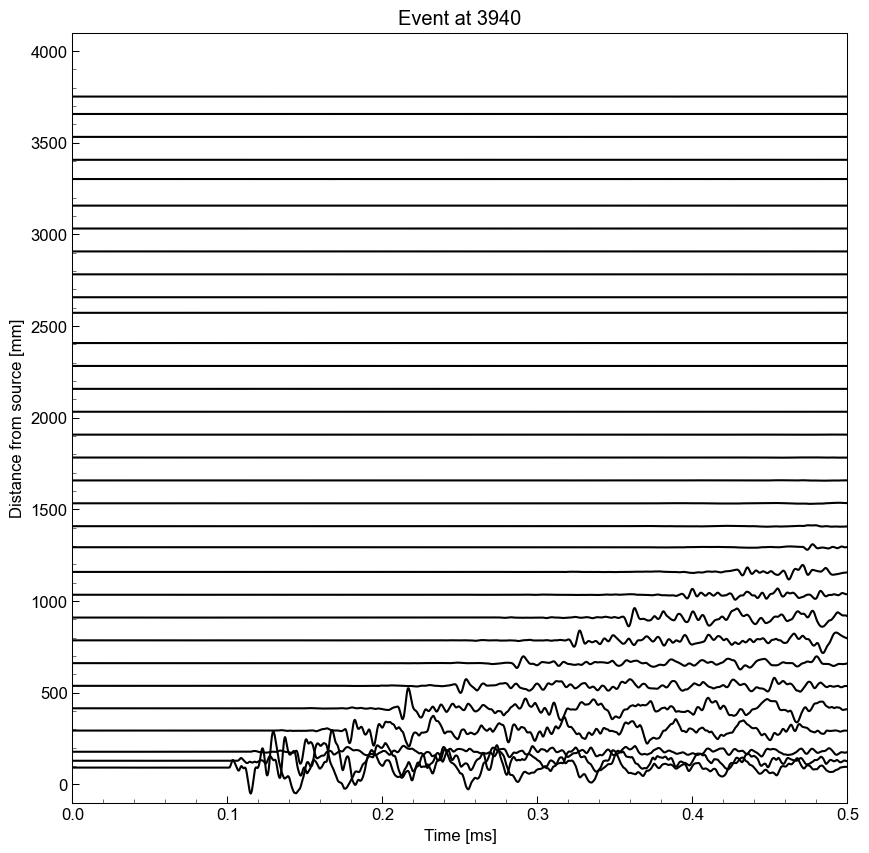

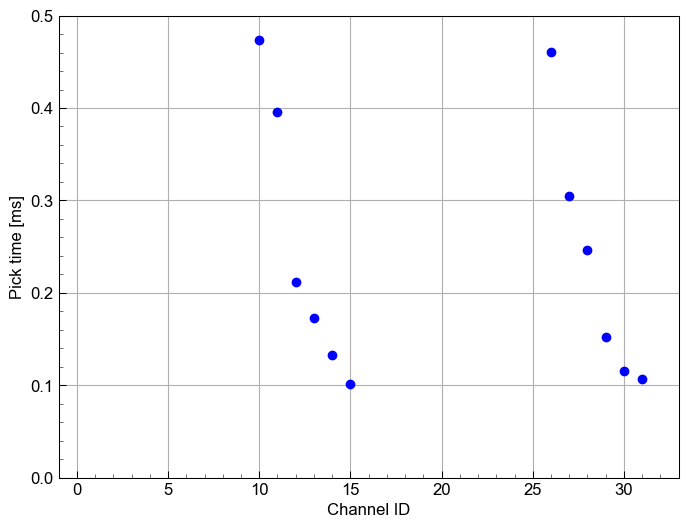

<Figure size 1000x1000 with 0 Axes>

In [35]:
figdir_traces = "../figure/debug_p01_compute_CF/debug_p01_traces_withdist"
if not os.path.exists(figdir_traces):
    os.makedirs(figdir_traces)
    
figdir_pick = "../figure/debug_p01_compute_CF/debug_p01_pick_firstarrival"
if not os.path.exists(figdir_pick):
    os.makedirs(figdir_pick)
    
figdir_initwave = "../figure/debug_p01_compute_CF/debug_p01_pick_initwave"
if not os.path.exists(figdir_initwave):
    os.makedirs(figdir_initwave)

figdir_errvar = "../figure/debug_p01_compute_CF/debug_p01_errvar"
if not os.path.exists(figdir_errvar):
    os.makedirs(figdir_errvar)
    
minargmax_tpick = 500 # [npts] pick the first arrival after this index; to avoid artifact in tapering.
 
    
for bx in bd_x:

    dataID = "{:04d}".format(bx)

    foname = os.path.join(outputdir, "BD_"+dataID+".pickle") 
    if os.path.exists(foname):
        print("{} already exists. skip this case.".format(dataID))
        # continue

    print("---------------\nStart Processing {}\n---------------\n".format(dataID))


    #---Select the traces associated with the event---#
    st_obs_raw = st_raw_bd.select(location=dataID)

    #--------------------------------------------------#
    #--- Remove instrumental response---#
    #--------------------------------------------------#

    st_obs = Stream()

    # Note: store both data with and without removal response for the comparison
    for tr in st_obs_raw:
        tr_removed =  remove_resp_digitalfilt(tr, poles, zeros, scale_fac, pre_filt=pre_filt, water_level=water_level, zero_mean=True,
                                                        taper=True, taper_fraction=0.05, detrend=True, debug=False) 
        tr_removed.data_noremoval = tr.data # store the raw data; after the response removal, the unit is in [m/s].
        st_obs.append(tr_removed)

    # skip removal
#     st_obs = st_obs_raw
    #---------------------------------------------------#
    #---------------------------------------------------#

    #---Compute distance---#

    AEsensor_loc={}
    source_loc=[bx, 0, 0]

    for i in range(len(df_array)):
        stnm = df_array.iloc[i].Instrument_Label
        station_loc = np.array(channel_loc[stnm])
        dist = np.linalg.norm(source_loc-station_loc)
        AEsensor_loc[stnm] = [dist, station_loc[0], station_loc[1], station_loc[2]]

    # tvec
    t = st_obs[0].times()*1e3 #[ms]

    ## Plot traces with distance 
    fig, ax = plt.subplots(1,1,figsize=(10, 10))

    # Plot observation
    normamp_obs = 5e-6
    for stnm in AEsensor_loc:
        tr = st_obs.select(station=stnm)[0]
        yshift = AEsensor_loc[stnm][0] # distance in [mm]
        ax.plot(t, tr.data/normamp_obs+yshift, "k-")

    ax.set_xlabel('Time [ms]')
    ax.set_ylabel('Distance from source [mm]')
    ax.set_title('Event at %s'%(dataID))
    # plt.gca().invert_yaxis()

    ax.set_xlim(0.0, 0.5)
    ax.set_ylim([-100, 4100])

    plt.savefig(figdir_traces+"/init_trace_dist_{}.png".format(dataID), format="png", dpi=70)
    print(dataID)
    
    #--------------------------------------------------------------#
    #---Compute Characteristic Function (CF)---#
    #--------------------------------------------------------------#

    tpick = {}    

    for tr in tqdm(st_obs):

        maxamp_id = np.argmax(np.abs(tr.data))
        st = t[maxamp_id] - fap_twin/2
        et = t[maxamp_id] + fap_twin/2

        fap = get_autopick_function(tr, FW, BW, st=st, et=et)
        # find first index exceeding autopick_threshold
        t_pick0 = np.argmax(fap>autopick_threshold)
        
        # shift tpick corresponding to the length of FW
        t_pick0 = t_pick0 + int(np.floor(FW/2))
        
        stnm = tr.stats.station
        st_obs.select(station=stnm)[0].fap = fap

        if (t_pick0 == 0) or (t_pick0 < minargmax_tpick):
            tpick[stnm] = np.nan
        else:
            tpick[stnm] = t[t_pick0]

#     tpick_sorted = sorted(tpick.items(), key=lambda x:x[1], reverse=False)
    tpick_sorted = sorted(tpick.items(), key=lambda x: np.inf if np.isnan(x[1]) else x[1], reverse=False) # ignore the nan
    tpick_sorted[:PickNumStation]

    tpick_time = np.sort(list(tpick.values()))
    fig, ax = plt.subplots(1,1,figsize=(8, 6))
    ax.set_xlim(-1,  33)
    ax.set_ylim(0, 0.5)
    ax.grid(True)
    ax.plot(list(tpick.values()), 'bo', ms=6)
    ax.set_xlabel("Channel ID")
    ax.set_ylabel("Pick time [ms]")
    plt.savefig(figdir_pick+"/fap_pick_distribution_{}.png".format(dataID), format="png", dpi=70)

    # debug Plot trace and fap
    fig, ax = plt.subplots(1,1,figsize=(10, 10))
    normamp_obs = 1e-5

    for (stnm, tp) in tpick_sorted[:PickNumStation]:
        tr = st_obs.select(station=stnm)[0]
        yshift = AEsensor_loc[stnm][0] # initial distance in [mm]
        ax.plot(t, tr.data/normamp_obs+yshift, "-")
        ax.plot(tpick[stnm], yshift, "+", ms=10, c='k')

    picktimes = sorted(list(tpick.values()), key=lambda x: np.inf if np.isnan(x) else x, reverse=False)
    ax.set_xlim(picktimes[0]-0.01, picktimes[0]+0.3)
    ax.set_xlabel('Time [ms]')
    ax.set_ylabel('Distance from source [mm]')
    ax.set_title('Event %s'%(dataID))
    ax.set_xlim(0.0, 0.5)
    
    figname = figdir_initwave+"/init_waveform_{}.png".format(dataID)
    plt.savefig(figname, dpi=70)
    
    #--------------------------------------------------------------#
    #---Conduct grid search for the best location---#
    #--------------------------------------------------------------#

    T, X, Y, V, R, Ermat, Vmat, Tmat, Xrng, Yrng  = eval_biax_4m_eventloc(tpick, st_obs, channel_loc, Vrng, PickNumStation=PickNumStation, 
                                                                          gridsize=gridsize, datacase=dataID, vfixed_id=vfixed_id)

    #--------------------------------------------------------------#
    #---Compute distance with inverted location---#
    #--------------------------------------------------------------#

    AEsensor_newloc={}
    source_loc=[X*1e3, Y*1e3, 0]

    for i in range(len(df_array)):
        stnm = df_array.iloc[i].Instrument_Label
        station_loc = np.array(channel_loc[stnm])
        dist = np.linalg.norm(source_loc-station_loc)
        AEsensor_newloc[stnm] = [dist, station_loc[0], station_loc[1], station_loc[2]]

    AEsensor_newloc

    fig, ax = plt.subplots(1,1,figsize=(12, 6))

    vmin = 1e-1 #5e-1
    vmax = 1e1 #2e1
    cmap = cm.jet

    Ermat = np.ma.masked_where(Ermat <= 0, Ermat)

    lev_exp = np.arange(np.floor(np.log10(vmin))-1e-9, np.ceil(np.log10(vmax))+1e-9, 0.01)
    levs = np.power(10, lev_exp)

    cs = ax.contourf(Xrng*1e3, Yrng*1e3, np.transpose(1e3*np.sqrt(Ermat)), levs, 
                     norm=LogNorm(vmin=vmin,vmax=vmax), cmap=cmap, extend='both') # plot in micro second

    ax.set_xlabel("x [mm]")
    ax.set_ylabel("y [mm]")
    ax.invert_yaxis()
    ax.set_aspect('equal', adjustable='box')

    cticks = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=LogNorm(vmin=vmin,vmax=vmax))
    cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', ticks=cticks, pad=0.2, extend='both')

    cbar.set_label(r'Standard deviation of pick time difference [$\mu$s]')

    # decorate figures
    # plot best location 
    ax.plot(X*1e3, Y*1e3, marker='x', markersize=10, color='w', mew=2)

    # plot location from project label
    ax.plot(float(dataID), 0, marker='s', markersize=8, color='w', mec='k')

    # plot location of stations
    xlimlist = []
    for i, (stnm, t1) in enumerate(tpick_sorted[:PickNumStation]):
        if np.isnan(t1):
            # skip this station
            continue;

        x1 = channel_loc[stnm][0]
        y1 = channel_loc[stnm][1]
        z1 = channel_loc[stnm][2]
        xlimlist.append(x1)
        # upper side
        if y1 >0:
            ax.plot(x1, y1-3, marker='^', markersize=10, color='c', mec='k')
        elif y1 < 0:
            ax.plot(x1, y1+3, marker='v', markersize=10, color='c', mec='k')

    xmin = np.sort(xlimlist)[0]-10
    xmax = np.sort(xlimlist)[-1]+10
    ax.set_xlim(xmin, xmax)
    ax.set_yticks([-50, -25, 0, 25, 50])
    figname = figdir_errvar+"/errvar_contour_{}.png".format(dataID)
    plt.savefig(figname, dpi=100)

    # reformat waveform and save data with location 

    st_obs.balldroploc = [X, Y]
    st_obs.origintime = T
    st_obs.velocity = V
    st_obs.errvar = R

    st_obs.FW = FW
    st_obs.BW = BW
    st_obs.tpick = tpick
    st_obs.PickNumStation = PickNumStation
    st_obs.gridsize = gridsize
    st_obs.AEsensor_newloc = AEsensor_newloc


    if not os.path.exists(outputdir):
        os.makedirs(outputdir)

    st_obs.write(foname, format="pickle")
    
    plt.close()
    plt.clf()

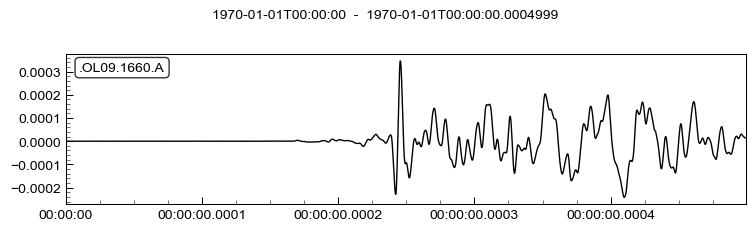

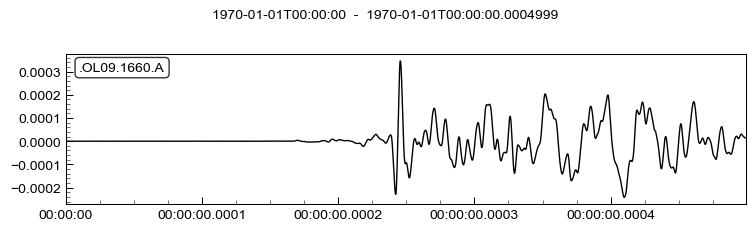

In [36]:
# check data


dataID = "{:04d}".format(bd_x[12])
finame = os.path.join(outputdir, "BD_"+dataID+".pickle") 

st = read(finame)
tr = st[8]
tr.plot()

In [37]:
bd_x

[220,
 340,
 460,
 580,
 700,
 820,
 940,
 1060,
 1180,
 1300,
 1420,
 1540,
 1660,
 1780,
 1900,
 2020,
 2140,
 2260,
 2380,
 2500,
 2620,
 2740,
 2860,
 2980,
 3100,
 3220,
 3340,
 3460,
 3580,
 3700,
 3820,
 3940]

In [38]:
scale_fac

array(894.99095553)

In [39]:
Xrng


array([3.81 , 3.811, 3.812, 3.813, 3.814, 3.815, 3.816, 3.817, 3.818,
       3.819, 3.82 , 3.821, 3.822, 3.823, 3.824, 3.825, 3.826, 3.827,
       3.828, 3.829, 3.83 , 3.831, 3.832, 3.833, 3.834, 3.835, 3.836,
       3.837, 3.838, 3.839, 3.84 , 3.841, 3.842, 3.843, 3.844, 3.845,
       3.846, 3.847, 3.848, 3.849, 3.85 , 3.851, 3.852, 3.853, 3.854,
       3.855, 3.856, 3.857, 3.858, 3.859, 3.86 , 3.861, 3.862, 3.863,
       3.864, 3.865, 3.866, 3.867, 3.868, 3.869, 3.87 , 3.871, 3.872,
       3.873, 3.874, 3.875, 3.876, 3.877, 3.878, 3.879, 3.88 , 3.881,
       3.882, 3.883, 3.884, 3.885, 3.886, 3.887, 3.888, 3.889, 3.89 ,
       3.891, 3.892, 3.893, 3.894, 3.895, 3.896, 3.897, 3.898, 3.899,
       3.9  , 3.901, 3.902, 3.903, 3.904, 3.905, 3.906, 3.907, 3.908,
       3.909, 3.91 , 3.911, 3.912, 3.913, 3.914, 3.915, 3.916, 3.917,
       3.918, 3.919, 3.92 , 3.921, 3.922, 3.923, 3.924, 3.925, 3.926,
       3.927, 3.928, 3.929, 3.93 , 3.931, 3.932, 3.933, 3.934, 3.935,
       3.936, 3.937,

In [40]:
tpick_sorted

[('OL16', 0.1012),
 ('OL32', 0.10679999999999999),
 ('OL31', 0.1155),
 ('OL15', 0.1331),
 ('OL30', 0.152),
 ('OL14', 0.17300000000000001),
 ('OL13', 0.212),
 ('OL29', 0.24640000000000004),
 ('OL28', 0.30479999999999996),
 ('OL12', 0.39540000000000003),
 ('OL27', 0.4611),
 ('OL11', 0.4734),
 ('OL01', nan),
 ('OL02', nan),
 ('OL03', nan),
 ('OL04', nan),
 ('OL05', nan),
 ('OL06', nan),
 ('OL07', nan),
 ('OL08', nan),
 ('OL09', nan),
 ('OL10', nan),
 ('OL17', nan),
 ('OL18', nan),
 ('OL19', nan),
 ('OL20', nan),
 ('OL21', nan),
 ('OL22', nan),
 ('OL23', nan),
 ('OL24', nan),
 ('OL25', nan),
 ('OL26', nan)]

In [41]:
dataID

'1660'

In [42]:
V,  X, Y, np.sqrt(R), Yrng

(6200.0,
 3.941,
 0.0010000000000000009,
 0.0004376220278116936,
 array([-0.05 , -0.049, -0.048, -0.047, -0.046, -0.045, -0.044, -0.043,
        -0.042, -0.041, -0.04 , -0.039, -0.038, -0.037, -0.036, -0.035,
        -0.034, -0.033, -0.032, -0.031, -0.03 , -0.029, -0.028, -0.027,
        -0.026, -0.025, -0.024, -0.023, -0.022, -0.021, -0.02 , -0.019,
        -0.018, -0.017, -0.016, -0.015, -0.014, -0.013, -0.012, -0.011,
        -0.01 , -0.009, -0.008, -0.007, -0.006, -0.005, -0.004, -0.003,
        -0.002, -0.001,  0.   ,  0.001,  0.002,  0.003,  0.004,  0.005,
         0.006,  0.007,  0.008,  0.009,  0.01 ,  0.011,  0.012,  0.013,
         0.014,  0.015,  0.016,  0.017,  0.018,  0.019,  0.02 ,  0.021,
         0.022,  0.023,  0.024,  0.025,  0.026,  0.027,  0.028,  0.029,
         0.03 ,  0.031,  0.032,  0.033,  0.034,  0.035,  0.036,  0.037,
         0.038,  0.039,  0.04 ,  0.041,  0.042,  0.043,  0.044,  0.045,
         0.046,  0.047,  0.048,  0.049,  0.05 ]))

In [43]:
int(np.floor(FW/2))

2

In [44]:
tpick_sorted[:PickNumStation]

[('OL16', 0.1012),
 ('OL32', 0.10679999999999999),
 ('OL31', 0.1155),
 ('OL15', 0.1331)]

In [45]:
dataID

'1660'

In [46]:
tpick_sorted = sorted(tpick.items(), key=lambda x: np.inf if np.isnan(x[1]) else x[1], reverse=False)
tpick_sorted

[('OL16', 0.1012),
 ('OL32', 0.10679999999999999),
 ('OL31', 0.1155),
 ('OL15', 0.1331),
 ('OL30', 0.152),
 ('OL14', 0.17300000000000001),
 ('OL13', 0.212),
 ('OL29', 0.24640000000000004),
 ('OL28', 0.30479999999999996),
 ('OL12', 0.39540000000000003),
 ('OL27', 0.4611),
 ('OL11', 0.4734),
 ('OL01', nan),
 ('OL02', nan),
 ('OL03', nan),
 ('OL04', nan),
 ('OL05', nan),
 ('OL06', nan),
 ('OL07', nan),
 ('OL08', nan),
 ('OL09', nan),
 ('OL10', nan),
 ('OL17', nan),
 ('OL18', nan),
 ('OL19', nan),
 ('OL20', nan),
 ('OL21', nan),
 ('OL22', nan),
 ('OL23', nan),
 ('OL24', nan),
 ('OL25', nan),
 ('OL26', nan)]

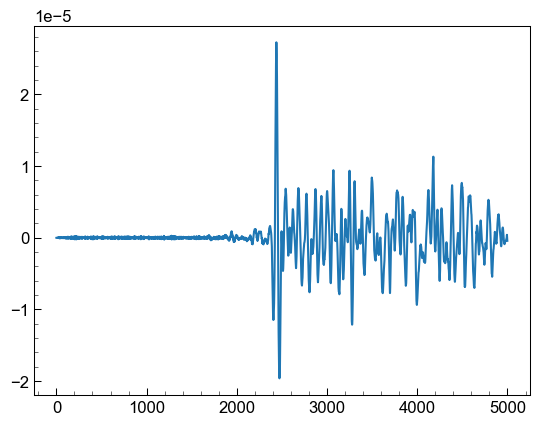

In [47]:
%matplotlib inline

plt.plot(np.diff(tr.data))
plt.show()

Text(0.5, 1.0, 'OL23')

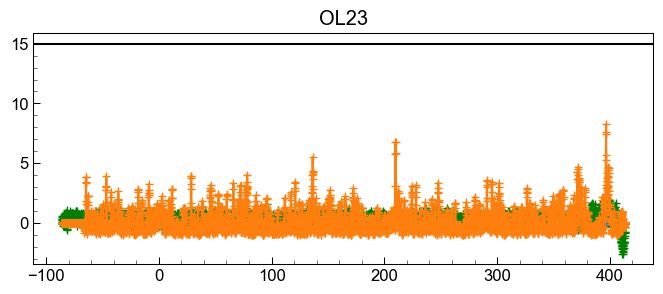

In [48]:
tr = st_obs[22]
ot = st_obs.origintime
fig, ax = plt.subplots(1,1,figsize=(8, 3))

ax.plot((t-ot)*1e3, tr.data*0.4e3, "+-")
ax.plot((t-ot)*1e3, tr.data_noremoval*0.4e3, "+-", c="g")
ax.plot((t-ot)*1e3, tr.fap, "+-")
ax.axvline((tpick[tr.stats.station]-ot)*1e3, c="r")
ax.axhline(15, c='k')
ax.set_title(tr.stats.station)

# ax.set_xlim(0.15-ot, 0.2-ot)
# ax.set_ylim(-50, 50)


In [49]:
FW*tr.stats.delta

5e-07

In [50]:
tr.stats

         network: 
         station: OL23
        location: 3940
         channel: A
       starttime: 1970-01-01T00:00:00.000000Z
         endtime: 1970-01-01T00:00:00.00049990Z
   sampling_rate: 10000000.0
           delta: 1e-07
            npts: 5000
           calib: 1.0
            dist: 2156.7162539379165
          i_iter: 2

In [51]:
picktimes = sorted(list(tpick.values()), key=lambda x: np.inf if np.isnan(x) else x, reverse=False)
picktimes

[0.1012,
 0.10679999999999999,
 0.1155,
 0.1331,
 0.152,
 0.17300000000000001,
 0.212,
 0.24640000000000004,
 0.30479999999999996,
 0.39540000000000003,
 0.4611,
 0.4734,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [52]:
    tpick_sorted[:PickNumStation]

[('OL16', 0.1012),
 ('OL32', 0.10679999999999999),
 ('OL31', 0.1155),
 ('OL15', 0.1331)]

In [53]:
channel_loc

{'OL01': [190.0, 50.0, 70.0],
 'OL02': [410.0, 50.0, 70.0],
 'OL03': [640.0, 50.0, 70.0],
 'OL04': [910.0, 50.0, 70.0],
 'OL05': [1160.0, 50.0, 70.0],
 'OL06': [1370.0, 50.0, 70.0],
 'OL07': [1660.0, 50.0, 70.0],
 'OL08': [1910.0, 50.0, 70.0],
 'OL09': [2160.0, 50.0, 70.0],
 'OL10': [2410.0, 50.0, 70.0],
 'OL11': [2650.0, 50.0, 70.0],
 'OL12': [2910.0, 50.0, 70.0],
 'OL13': [3160.0, 50.0, 70.0],
 'OL14': [3410.0, 50.0, 70.0],
 'OL15': [3660.0, 50.0, 70.0],
 'OL16': [3910.0, 50.0, 70.0],
 'OL17': [285.0, -50.0, 70.0],
 'OL18': [535.0, -50.0, 70.0],
 'OL19': [785.0, -50.0, 70.0],
 'OL20': [1035.0, -50.0, 70.0],
 'OL21': [1285.0, -50.0, 70.0],
 'OL22': [1535.0, -50.0, 70.0],
 'OL23': [1785.0, -50.0, 70.0],
 'OL24': [2035.0, -50.0, 70.0],
 'OL25': [2285.0, -50.0, 70.0],
 'OL26': [2535.0, -50.0, 70.0],
 'OL27': [2785.0, -50.0, 70.0],
 'OL28': [3035.0, -50.0, 70.0],
 'OL29': [3285.0, -50.0, 70.0],
 'OL30': [3535.0, -50.0, 70.0],
 'OL31': [3785.0, -50.0, 70.0],
 'OL32': [4035.0, -50.0, 70.0]}